Login detail

In [ ]:
account = 123123 # Replace with your login ID
password = "123123" # Replace with your password
server = "VantageInternational-Demo" # Replace with your broker server

Data fetching

In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import pytz
import datetime
from pathlib import Path

# === MT5 Connection Config ===
MT5_CONFIG = {
    "path": r"C:\Program Files\MetaTrader 5\terminal64.exe",  # Update with your MT5 path
    "login": account,  # Replace with your login ID
    "password": password,  # Replace with your password
    "server": server,  # Replace with your broker server
}

SYMBOL = "BTCUSD"
TIMEFRAME = "M1"
# BARS_NEEDED =  525600 # You can change this to how many recent bars you want
BARS_NEEDED =  525600
# === Timeframe Mapping ===
TIMEFRAME_MAP = {
    "M1": mt5.TIMEFRAME_M1,
    "M5": mt5.TIMEFRAME_M5,
    "M15": mt5.TIMEFRAME_M15,
    "H1": mt5.TIMEFRAME_H1,
    "H4": mt5.TIMEFRAME_H4,
    "D1": mt5.TIMEFRAME_D1,
}

# === Connect to MT5 ===
def connect_mt5():
    if not mt5.initialize(
        path=MT5_CONFIG["path"],
        login=MT5_CONFIG["login"],
        password=MT5_CONFIG["password"],
        server=MT5_CONFIG["server"]
    ):
        print("MT5 Initialization Failed:", mt5.last_error())
        return False
    print("Connected to MT5:", mt5.version())
    return True

# === Fetch Recent Data ===
def fetch_recent_data(symbol, timeframe_str, bars_needed):
    tf_enum = TIMEFRAME_MAP.get(timeframe_str)
    rates = mt5.copy_rates_from_pos(symbol, tf_enum, 0, bars_needed)
    
    if rates is None or len(rates) == 0:
        print("No data received.")
        return None
    
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

# === Main ===
if __name__ == "__main__":
    if connect_mt5():
        df = fetch_recent_data(SYMBOL, TIMEFRAME, BARS_NEEDED)
        if df is not None:
            print(df.tail())

            # Save directly to current script directory
            filename = Path("BTCUSD_M1_live_raw.csv")
            df.to_csv(filename)
            print(f"Saved recent data to {filename}")

        mt5.shutdown()


Connected to MT5: (500, 5135, '27 Jun 2025')
                          open       high        low      close  tick_volume  \
time                                                                           
2025-07-28 17:41:00  118055.78  118181.22  118039.75  118177.45          220   
2025-07-28 17:42:00  118177.22  118196.34  118140.02  118148.04          192   
2025-07-28 17:43:00  118148.10  118238.36  118147.23  118199.57          184   
2025-07-28 17:44:00  118207.78  118259.58  118207.78  118250.15          199   
2025-07-28 17:45:00  118250.56  118272.44  118213.19  118240.21          111   

                     spread  real_volume  
time                                      
2025-07-28 17:41:00    1794            0  
2025-07-28 17:42:00    1794            0  
2025-07-28 17:43:00    1794            0  
2025-07-28 17:44:00    1794            0  
2025-07-28 17:45:00    1794            0  
Saved recent data to BTCUSD_M1_live_raw.csv


Model Training

Raw data split - Train: 367920, Val: 78840, Test: 78840
After feature engineering and dropping NAs - Train: 271003, Val: 50035, Test: 39776
Feature vector length: 80
Train - UP: 135669, DOWN: 135319
Val - UP: 25417, DOWN: 24603
Test - UP: 20171, DOWN: 19590
Scaler saved as 'robust_scaler.pkl'
Train: Counter({1: 135669, 0: 135319})
Validation: Counter({1: 25417, 0: 24603})
Test: Counter({1: 20171, 0: 19590})

Training Ridge Regression model...
Ridge Validation Accuracy: 0.5115
Ridge Validation AUC: 0.5172
Ridge model saved as 'ridge_classifier.pkl'

Training Bayesian Neural Network...
Epoch 1/50: Train Loss: 0.6870, Val Loss: 0.6625, Val Acc: 0.5810, Val AUC: 0.6276
Epoch 2/50: Train Loss: 0.6697, Val Loss: 0.6515, Val Acc: 0.5926, Val AUC: 0.6528
Epoch 3/50: Train Loss: 0.6619, Val Loss: 0.6469, Val Acc: 0.6054, Val AUC: 0.6593
Epoch 4/50: Train Loss: 0.6571, Val Loss: 0.6445, Val Acc: 0.6053, Val AUC: 0.6641
Epoch 5/50: Train Loss: 0.6530, Val Loss: 0.6450, Val Acc: 0.6052, Val AUC: 0

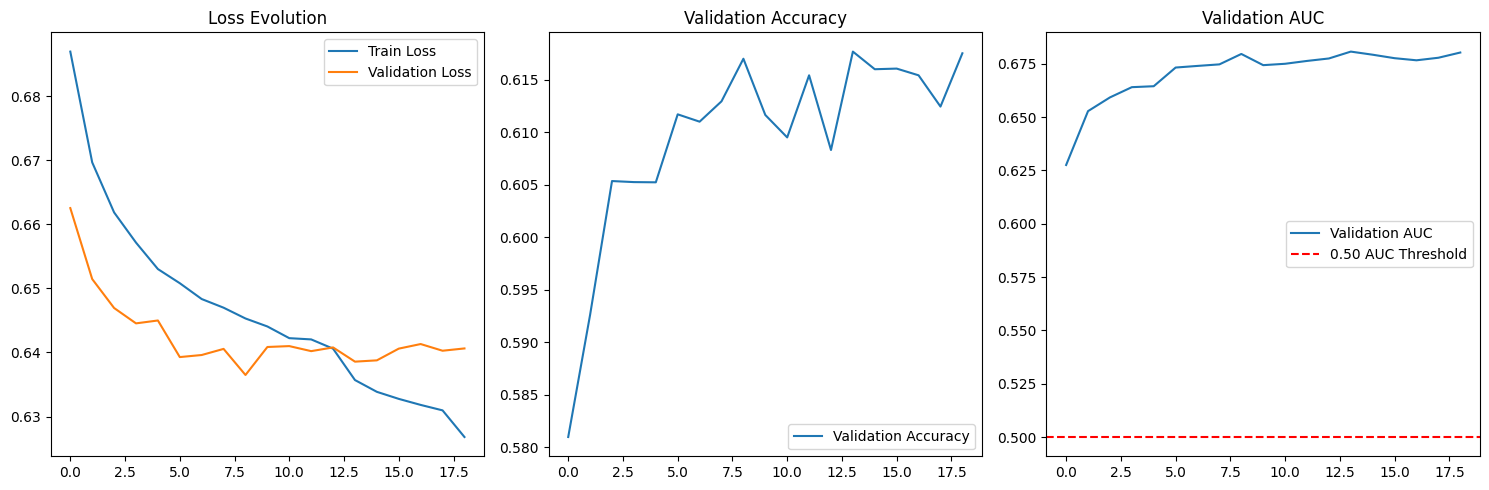

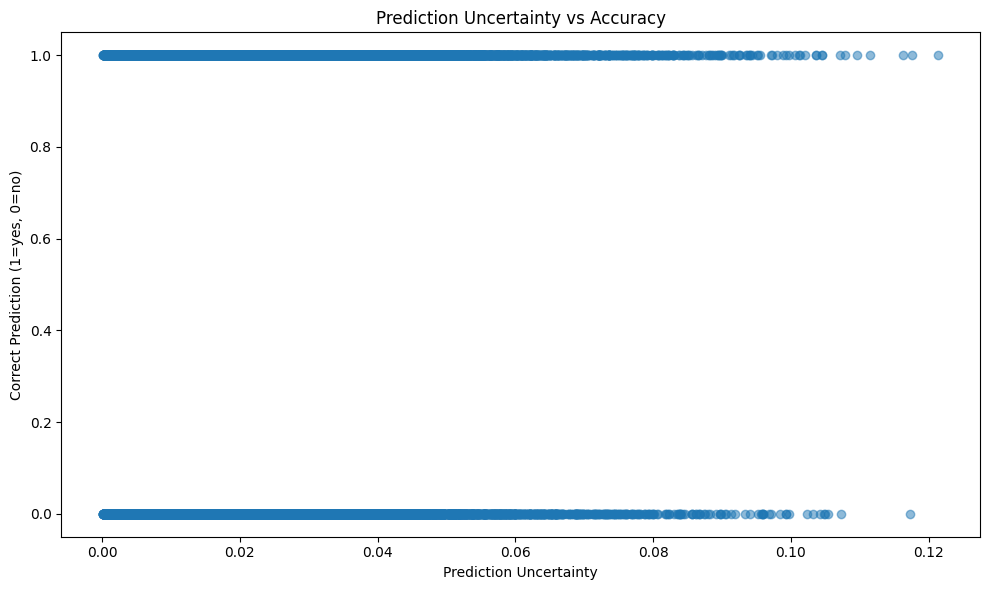

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
import talib
from collections import Counter
import matplotlib.pyplot as plt
import os
import joblib
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define global parameters
BAR_HORIZON = 30
SEQUENCE_LENGTH = 15
SUPPORT_RESISTANCE_WINDOW = 200

# --- Improved Label Creation ---
def create_binary_labels(df, tp_target=0.002, tolerance_ratio=0.95):
    # Use global BAR_HORIZON instead of default parameter
    df = df.copy()
    close = df['close'].values
    targets = []

    for i in range(len(close)):
        if i >= len(close) - BAR_HORIZON:
            targets.append(np.nan)
            continue

        current_price = close[i]
        future_prices = close[i+1:i+1+BAR_HORIZON]
        
        # Track first target hit
        label = np.nan
        for j, price in enumerate(future_prices):
            ret = (price - current_price) / current_price
            if ret >= tp_target * tolerance_ratio:
                label = 1  # UP target hit
                break
            elif ret <= -tp_target * tolerance_ratio:
                label = -1  # DOWN target hit
                break
                
        targets.append(label)

    df['target'] = targets
    return df

# --- Enhanced Feature Engineering focused on patterns ---
def apply_feature_engineering(df):
    df = df.copy()
    # Momentum Indicators
    df['rsi_14'] = talib.RSI(df['close'], 14)
    df['rsi_5'] = talib.RSI(df['close'], 5)
    df['rsi_divergence'] = df['rsi_14'] - df['rsi_5']
    df['macd'], df['macd_signal'], df['macd_hist'] = talib.MACD(df['close'], 12, 26, 9)
    
    # Market regime features (trending vs ranging)
    df['adx'] = talib.ADX(df['high'], df['low'], df['close'], 14)
    df['trending_market'] = df['adx'] > 25
    
    # Volatility metrics
    df['atr_14'] = talib.ATR(df['high'], df['low'], df['close'], 14)
    df['atr_volatility'] = df['atr_14'] / df['close']
    df['upper'], df['middle'], df['lower'] = talib.BBANDS(df['close'], timeperiod=20)
    df['bb_width'] = (df['upper'] - df['lower']) / df['middle']
    
    # Pattern recognition (not sequence memorization)
    df['doji'] = ((df['close'] - df['open']).abs() / (df['high'] - df['low']) < 0.1).astype(float)
    df['engulfing'] = (
        ((df['close'] > df['open']) & 
         (df['open'].shift(1) > df['close'].shift(1)) & 
         (df['open'] <= df['close'].shift(1)) & 
         (df['close'] >= df['open'].shift(1)))
        |
        ((df['close'] < df['open']) & 
         (df['open'].shift(1) < df['close'].shift(1)) & 
         (df['open'] >= df['close'].shift(1)) & 
         (df['close'] <= df['open'].shift(1)))
    ).astype(float)
    
    # Relative position features
    df['close_to_high'] = (df['high'] - df['close']) / (df['high'] - df['low'])
    df['close_to_low'] = (df['close'] - df['low']) / (df['high'] - df['low'])
    
    # Moving average patterns
    df['ema_5'] = talib.EMA(df['close'], 5)
    df['ema_20'] = talib.EMA(df['close'], 20)
    df['ema_50'] = talib.EMA(df['close'], 50)
    df['ema_5_20_cross'] = ((df['ema_5'] > df['ema_20']) & 
                          (df['ema_5'].shift(1) <= df['ema_20'].shift(1))).astype(float)
    df['ema_20_50_cross'] = ((df['ema_20'] > df['ema_50']) & 
                           (df['ema_20'].shift(1) <= df['ema_50'].shift(1))).astype(float)
    
    # Volume analysis
    df['volume_ma'] = df['tick_volume'].rolling(20).mean()
    df['volume_ratio'] = df['tick_volume'] / df['volume_ma']
    df['volume_price_trend'] = df['close'] * df['tick_volume']
    df['obv'] = talib.OBV(df['close'], df['tick_volume'])
    df['obv_ma'] = talib.SMA(df['obv'], 20)
    df['obv_slope'] = df['obv'] - df['obv'].shift(5)
    
    # Supply and demand zones 
    df['swing_high'] = df['high'].rolling(SUPPORT_RESISTANCE_WINDOW, center=False).max()
    df['swing_low'] = df['low'].rolling(SUPPORT_RESISTANCE_WINDOW, center=False).min()
    df['dist_to_high'] = (df['swing_high'] - df['close']) / df['close']
    df['dist_to_low'] = (df['close'] - df['swing_low']) / df['close']
    
    return df

# Updated feature columns based on pattern recognition
feature_columns = [
    'rsi_14', 'rsi_5', 'rsi_divergence', 
    'macd', 'macd_signal', 'macd_hist',
    'adx', 'trending_market',
    'atr_volatility', 'bb_width',
    'doji', 'engulfing',
    'close_to_high', 'close_to_low',
    'ema_5_20_cross', 'ema_20_50_cross',
    'volume_ratio', 'obv_slope',
    'dist_to_high', 'dist_to_low'
]

num_features = len(feature_columns)

# ===== IMPROVED DATA PROCESSING PIPELINE TO PREVENT LEAKAGE =====
# 1. Load data
raw_df = pd.read_csv("BTCUSD_M1_live_raw.csv")

# 2. Split raw data chronologically FIRST (before any feature engineering)
total_raw_size = len(raw_df)
train_raw_size = int(0.7 * total_raw_size)
val_raw_size = int(0.15 * total_raw_size)

train_raw_df = raw_df.iloc[:train_raw_size].copy().reset_index(drop=True)
val_raw_df = raw_df.iloc[train_raw_size:train_raw_size+val_raw_size].copy().reset_index(drop=True)
test_raw_df = raw_df.iloc[train_raw_size+val_raw_size:].copy().reset_index(drop=True)

print(f"Raw data split - Train: {len(train_raw_df)}, Val: {len(val_raw_df)}, Test: {len(test_raw_df)}")

# 3. Apply feature engineering and create labels separately for each split
# Training set
train_df = apply_feature_engineering(train_raw_df)
train_df = create_binary_labels(train_df, tp_target=0.002, tolerance_ratio=0.95)
train_df = train_df.dropna().reset_index(drop=True)

# Validation set
val_df = apply_feature_engineering(val_raw_df)
val_df = create_binary_labels(val_df, tp_target=0.002, tolerance_ratio=0.95)
val_df = val_df.dropna().reset_index(drop=True)

# Test set
test_df = apply_feature_engineering(test_raw_df)
test_df = create_binary_labels(test_df, tp_target=0.002, tolerance_ratio=0.95)
test_df = test_df.dropna().reset_index(drop=True)

print(f"After feature engineering and dropping NAs - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# 5. Feature extraction with reduced emphasis on sequences - FIXED VERSION
def extract_features(data_df):
    # Use global SEQUENCE_LENGTH (5) instead of a parameter
    features = data_df[feature_columns].values
    targets = data_df['target'].values
    X, y = [], []
    
    for i in range(SEQUENCE_LENGTH, len(features)):
        try:
            # Create features focused on patterns, not just raw sequences
            seq = features[i-SEQUENCE_LENGTH:i].astype(float)  # Convert to float
            
            # Extract statistical properties instead of raw time series
            feat_vec = []
            # Last observation
            feat_vec.extend(seq[-1])
            
            # Mean of sequence
            feat_vec.extend(np.mean(seq, axis=0))
            
            # Safe standard deviation calculation
            std_vals = []
            for col in range(seq.shape[1]):
                col_data = seq[:, col]
                try:
                    std_val = np.std(col_data)
                    if np.isnan(std_val) or np.isinf(std_val):
                        std_val = 0.0
                except:
                    std_val = 0.0
                std_vals.append(std_val)
            feat_vec.extend(std_vals)
            
            # Trend (simple linear regression slope)
            for col in range(seq.shape[1]):
                x = np.arange(SEQUENCE_LENGTH)
                y_col = seq[:, col]
                # Simple trend calculation with error handling
                try:
                    if np.std(y_col) > 0:
                        slope = np.polyfit(x, y_col, 1)[0]
                    else:
                        slope = 0.0
                except:
                    slope = 0.0
                feat_vec.append(slope)
            
            # Convert to numpy array and check for invalid values
            feat_vec = np.array(feat_vec, dtype=float)
            if not np.any(np.isnan(feat_vec)) and not np.any(np.isinf(feat_vec)):
                X.append(feat_vec)
                y.append(targets[i])
                
        except Exception as e:
            # Skip this sample if any error occurs
            continue
    
    if len(X) == 0:
        raise ValueError("No valid feature vectors were created. Check your data.")
        
    return np.array(X), np.array(y)

# Extract features for each split separately
X_train, y_train = extract_features(train_df)
X_val, y_val = extract_features(val_df)
X_test, y_test = extract_features(test_df)

print(f"Feature vector length: {X_train.shape[1]}")
print(f"Train - UP: {(y_train == 1).sum()}, DOWN: {(y_train == -1).sum()}")
print(f"Val - UP: {(y_val == 1).sum()}, DOWN: {(y_val == -1).sum()}")
print(f"Test - UP: {(y_test == 1).sum()}, DOWN: {(y_test == -1).sum()}")

# 7. Scale features AFTER split (prevent leakage)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)  # Fit only on training data
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'robust_scaler.pkl')
print("Scaler saved as 'robust_scaler.pkl'")

# Map labels for classification
label_map = {-1: 0, 1: 1}
y_train_mapped = np.vectorize(label_map.get)(y_train)
y_val_mapped = np.vectorize(label_map.get)(y_val)
y_test_mapped = np.vectorize(label_map.get)(y_test)

print(f"Train: {Counter(y_train_mapped)}")
print(f"Validation: {Counter(y_val_mapped)}")
print(f"Test: {Counter(y_test_mapped)}")

# ===== RIDGE REGRESSION MODEL (as suggested in the comment) =====
print("\nTraining Ridge Regression model...")
# We'll use LogisticRegression with L2 regularization instead of Ridge since we need classification
ridge_classifier = LogisticRegression(
    penalty='l2',  # L2 regularization as in Ridge
    C=0.1,         # Regularization strength (inverse of alpha in Ridge)
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
ridge_classifier.fit(X_train, y_train_mapped)

# Evaluate Ridge model
ridge_val_preds = ridge_classifier.predict(X_val)
ridge_val_proba = ridge_classifier.predict_proba(X_val)[:, 1]
ridge_val_acc = accuracy_score(y_val_mapped, ridge_val_preds)
ridge_val_auc = roc_auc_score(y_val_mapped, ridge_val_proba)

print(f"Ridge Validation Accuracy: {ridge_val_acc:.4f}")
print(f"Ridge Validation AUC: {ridge_val_auc:.4f}")

# Save Ridge model
joblib.dump(ridge_classifier, 'ridge_classifier.pkl')
print("Ridge model saved as 'ridge_classifier.pkl'")

# ===== NEURAL NETWORK MODEL =====
# Convert to tensors for neural network
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_mapped, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_mapped, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_mapped, dtype=torch.long)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

# Bayesian-inspired Neural Network
class BayesianMLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.ln2 = nn.LayerNorm(hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.ln3 = nn.LayerNorm(hidden_size // 4)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc4 = nn.Linear(hidden_size // 4, 2)
        
    def forward(self, x):
        # Using dropout for approximate Bayesian inference
        x = self.dropout1(F.leaky_relu(self.ln1(self.fc1(x))))
        x = self.dropout2(F.leaky_relu(self.ln2(self.fc2(x))))
        x = self.dropout3(F.leaky_relu(self.ln3(self.fc3(x))))
        x = self.fc4(x)
        return x
    
    def predict_with_uncertainty(self, x, n_samples=50):
        """Monte Carlo Dropout for uncertainty estimation"""
        self.train()  # Set to training mode to enable dropout
        outputs = []
        for _ in range(n_samples):
            outputs.append(F.softmax(self(x), dim=1).unsqueeze(0))
        outputs = torch.cat(outputs, dim=0)
        mean = outputs.mean(dim=0)
        uncertainty = outputs.var(dim=0).sum(dim=1)
        return mean, uncertainty

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BayesianMLP(input_size=X_train.shape[1]).to(device)

# Calculate class weights
counts = np.bincount(y_train_mapped)
total = len(y_train_mapped)
down_weight = total / (2 * counts[0])
up_weight = total / (2 * counts[1])
class_weights = torch.tensor([down_weight, up_weight], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

def train_model(model, train_loader, val_loader, epochs=50, patience=5):
    best_auc, best_epoch, epochs_no_improve = 0.0, 0, 0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}
    os.makedirs("checkpoints", exist_ok=True)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)

        model.eval()
        val_loss, correct, total = 0, 0, 0
        all_probs, all_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                val_loss += criterion(outputs, yb).item() * xb.size(0)
                probs = F.softmax(outputs, dim=1)
                all_probs.extend(probs[:, 1].cpu().numpy())
                all_targets.extend(yb.cpu().numpy())
                _, preds = torch.max(outputs, 1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        val_auc = roc_auc_score(all_targets, all_probs)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)
        scheduler.step(val_auc)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            best_epoch = epoch
            epochs_no_improve = 0
            torch.save(model.state_dict(), "checkpoints/best_bayesian_model_weights.pth")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load("checkpoints/best_bayesian_model_weights.pth"))
    return best_auc, history

print("\nTraining Bayesian Neural Network...")
best_val_auc, history = train_model(model, train_loader, val_loader)
print(f"\nBest Validation AUC: {best_val_auc:.4f}")

# Test evaluation with uncertainty estimation
model.eval()
all_preds, all_targets, all_uncertainties = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        probs, uncertainty = model.predict_with_uncertainty(xb)
        _, preds = torch.max(probs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(yb.cpu().numpy())
        all_uncertainties.extend(uncertainty.cpu().numpy())

# Map back to original labels
reverse_map = {0: -1, 1: 1}
all_preds_original = [reverse_map[p] for p in all_preds]
all_targets_original = [reverse_map[t] for t in all_targets]

# Calculate metrics
test_acc = accuracy_score(all_targets_original, all_preds_original)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(classification_report(all_targets_original, all_preds_original, target_names=['DOWN', 'UP']))

# ===== ENSEMBLE MODEL =====
# Create ensemble predictions by combining Ridge and Neural Network
print("\nCreating ensemble predictions...")
# Get neural network probabilities
model.eval()
nn_probs = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = F.softmax(model(xb), dim=1)
        nn_probs.extend(probs[:, 1].cpu().numpy())

# Get Ridge probabilities
ridge_probs = ridge_classifier.predict_proba(X_test)[:, 1]

# Simple ensemble: average probabilities
ensemble_probs = 0.4 * ridge_probs + 0.6 * np.array(nn_probs)
ensemble_preds = (ensemble_probs > 0.5).astype(int)
ensemble_preds_original = [reverse_map[p] for p in ensemble_preds]

# Calculate ensemble metrics
ensemble_acc = accuracy_score(all_targets_original, ensemble_preds_original)
ensemble_auc = roc_auc_score(y_test_mapped, ensemble_probs)
print(f"\nEnsemble Test Accuracy: {ensemble_acc:.4f}")
print(f"Ensemble Test AUC: {ensemble_auc:.4f}")
print(classification_report(all_targets_original, ensemble_preds_original, target_names=['DOWN', 'UP']))

# Save models and metadata
torch.save(model.state_dict(), "final_bayesian_model_weights.pth")
joblib.dump({
    'feature_columns': feature_columns,
    'scaler': scaler,
    'ridge_classifier': ridge_classifier
}, "model_metadata.pkl")
print("All models saved.")

# Plot training history with AUC
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['val_auc'], label='Validation AUC')
plt.title('Validation AUC')
plt.axhline(y=0.50, color='r', linestyle='--', label='0.50 AUC Threshold')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
print("Training history plot saved as 'training_history.png'")

# High uncertainty analysis
uncertainty_threshold = np.percentile(all_uncertainties, 80)
high_uncertainty_idx = np.where(np.array(all_uncertainties) > uncertainty_threshold)[0]
print(f"\nHigh uncertainty predictions: {len(high_uncertainty_idx)}/{len(all_uncertainties)}")

# Plot uncertainty vs accuracy
plt.figure(figsize=(10, 6))
plt.scatter(all_uncertainties, 
            np.array(all_preds_original) == np.array(all_targets_original),
            alpha=0.5)
plt.xlabel('Prediction Uncertainty')
plt.ylabel('Correct Prediction (1=yes, 0=no)')
plt.title('Prediction Uncertainty vs Accuracy')
plt.tight_layout()
plt.savefig('uncertainty_vs_accuracy.png')
print("Uncertainty analysis plot saved as 'uncertainty_vs_accuracy.png'")


Sample Test Predictions with Confidence:
    True_Label  Predicted_Label  Confidence_UP  Confidence_DOWN  Uncertainty  \
0            1               -1       0.420571         0.579429     0.026949   
1            1                1       0.505745         0.494255     0.025909   
2            1               -1       0.392602         0.607398     0.025747   
3            1               -1       0.434485         0.565515     0.029306   
4            1               -1       0.462207         0.537793     0.022964   
5            1               -1       0.432294         0.567706     0.025530   
6            1               -1       0.455145         0.544855     0.012666   
7            1               -1       0.478416         0.521583     0.006496   
8            1               -1       0.463443         0.536557     0.010865   
9            1               -1       0.482696         0.517304     0.002984   
10           1               -1       0.510121         0.489879     0.001903  

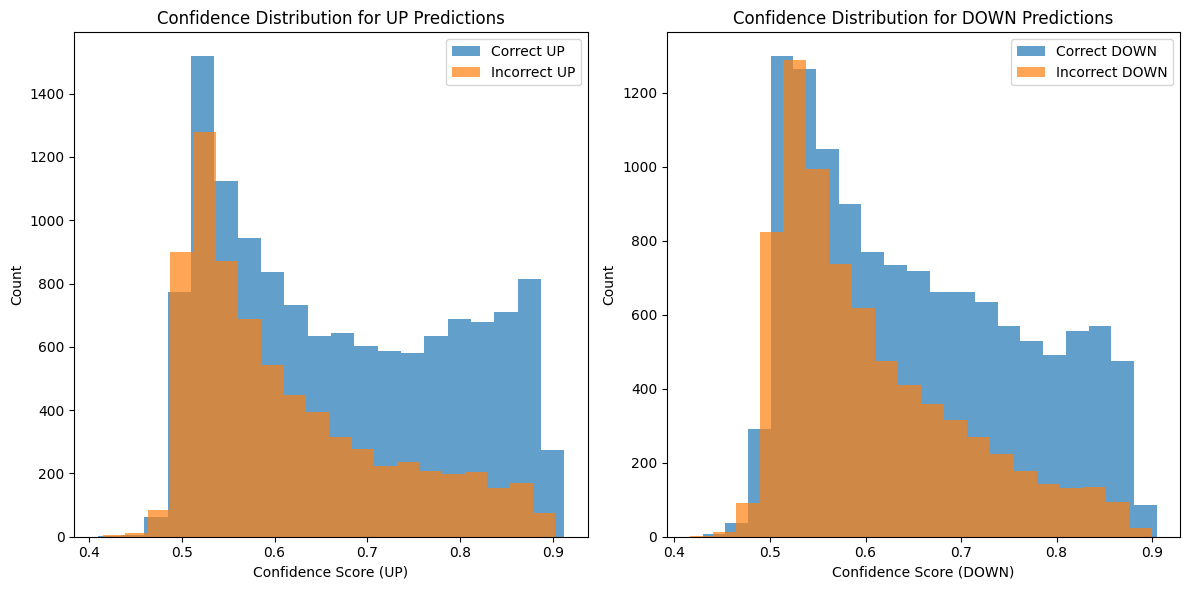

In [60]:
# Create a DataFrame to display predictions and confidence scores
with torch.no_grad():  # Add this to disable gradient tracking
    mean_probs, uncertainties = model.predict_with_uncertainty(X_test_tensor.to(device))
    mean_probs = mean_probs.cpu().detach().numpy()  # Properly detach before converting to numpy

test_results = pd.DataFrame({
    'True_Label': all_targets_original,
    'Predicted_Label': all_preds_original,
    'Confidence_UP': mean_probs[:, 1],  # UP class confidence
    'Confidence_DOWN': mean_probs[:, 0],  # DOWN class confidence
    'Uncertainty': all_uncertainties,
    'Correct': np.array(all_preds_original) == np.array(all_targets_original)
})

# Display the first 20 predictions with their confidence scores
print("\nSample Test Predictions with Confidence:")
print(test_results.head(20))

# Save the full results to CSV
test_results.to_csv('test_predictions_confidence.csv', index=False)
print("Full test predictions and confidence scores saved to 'test_predictions_confidence.csv'")

# Visualize confidence distribution for correct vs incorrect predictions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
correct_idx = test_results['Correct']
incorrect_idx = ~test_results['Correct']

# For UP predictions, show confidence distribution
up_preds = test_results['Predicted_Label'] == 1
plt.hist(test_results.loc[correct_idx & up_preds, 'Confidence_UP'], alpha=0.7, bins=20, label='Correct UP')
plt.hist(test_results.loc[incorrect_idx & up_preds, 'Confidence_UP'], alpha=0.7, bins=20, label='Incorrect UP')
plt.xlabel('Confidence Score (UP)')
plt.ylabel('Count')
plt.legend()
plt.title('Confidence Distribution for UP Predictions')

plt.subplot(1, 2, 2)
# For DOWN predictions, show confidence distribution
down_preds = test_results['Predicted_Label'] == -1
plt.hist(test_results.loc[correct_idx & down_preds, 'Confidence_DOWN'], alpha=0.7, bins=20, label='Correct DOWN')
plt.hist(test_results.loc[incorrect_idx & down_preds, 'Confidence_DOWN'], alpha=0.7, bins=20, label='Incorrect DOWN')
plt.xlabel('Confidence Score (DOWN)')
plt.ylabel('Count')
plt.legend()
plt.title('Confidence Distribution for DOWN Predictions')

plt.tight_layout()
plt.savefig('prediction_confidence_distribution.png')
print("Prediction confidence distribution plot saved as 'prediction_confidence_distribution.png'")

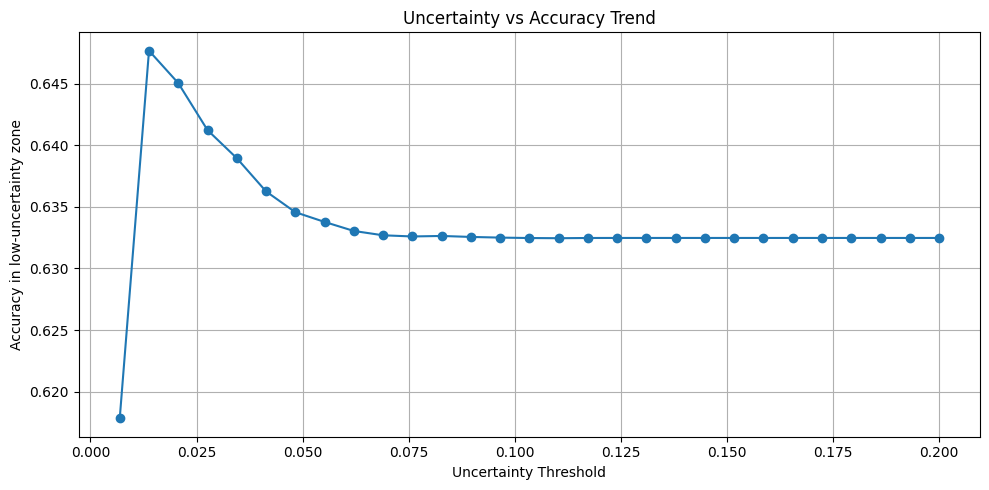

In [61]:
import matplotlib.pyplot as plt

thresholds = np.linspace(0, 0.2, 30)
accuracies = []

for t in thresholds:
    mask = np.array(all_uncertainties) < t
    correct = (np.array(all_preds_original) == np.array(all_targets_original))[mask]
    acc = correct.sum() / len(correct) if len(correct) > 0 else np.nan
    accuracies.append(acc)

plt.figure(figsize=(10,5))
plt.plot(thresholds, accuracies, marker='o')
plt.xlabel("Uncertainty Threshold")
plt.ylabel("Accuracy in low-uncertainty zone")
plt.title("Uncertainty vs Accuracy Trend")
plt.grid(True)
plt.tight_layout()
plt.show()


In [69]:
import numpy as np

# Convert to arrays for filtering
uncertainties = np.array(all_uncertainties)
correct_preds = (np.array(all_preds_original) == np.array(all_targets_original))

# Step 1: Baseline (no filter)
baseline_acc = correct_preds.sum() / len(correct_preds)
print(f"\n🧾 Baseline Accuracy (All Samples): {baseline_acc:.4f}  | Total Samples: {len(correct_preds)}")

# Step 2: Filtered by Uncertainty
threshold = 0.015  # ← You can try 0.015, 0.03, etc.
filtered_mask = uncertainties < threshold
filtered_correct = correct_preds[filtered_mask]

filtered_count = filtered_mask.sum()
filtered_acc = filtered_correct.sum() / filtered_count if filtered_count > 0 else 0

print(f"🧪 Filtered Accuracy (Uncertainty < {threshold}): {filtered_acc:.4f}  | Samples: {filtered_count}")

# Optional: Precision boost
acc_boost = filtered_acc - baseline_acc
print(f"🎯 Accuracy Gain from Filtering: {acc_boost:.4f}")



🧾 Baseline Accuracy (All Samples): 0.6325  | Total Samples: 39761
🧪 Filtered Accuracy (Uncertainty < 0.015): 0.6483  | Samples: 23747
🎯 Accuracy Gain from Filtering: 0.0158


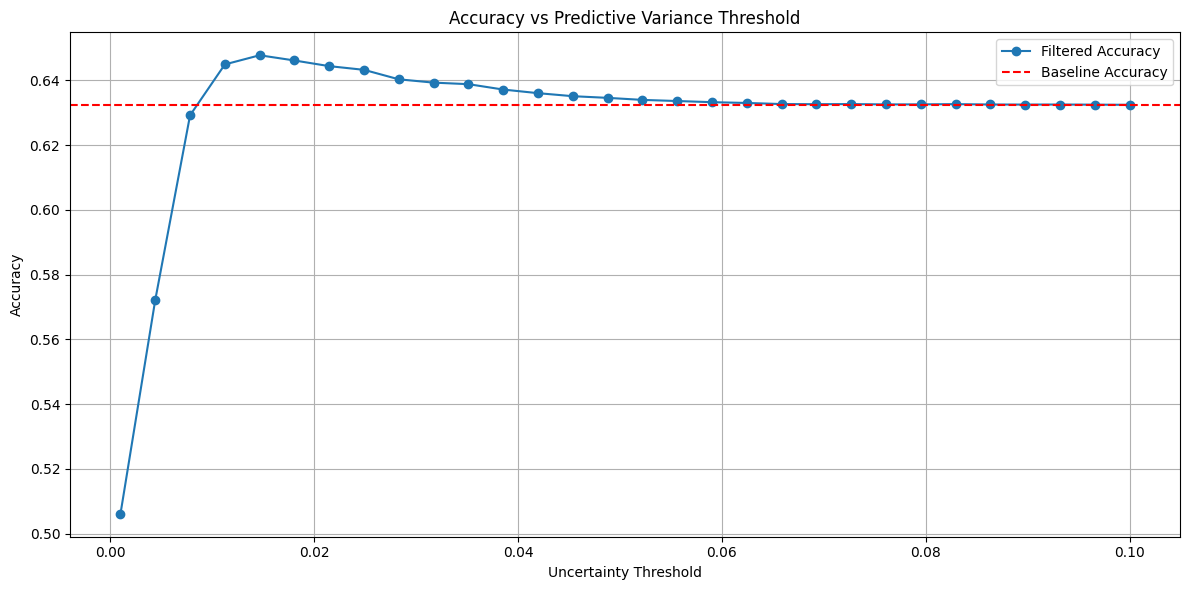

In [70]:
import matplotlib.pyplot as plt

thresholds = np.linspace(0.001, 0.1, 30)
accuracies = []
sample_sizes = []

for t in thresholds:
    mask = uncertainties < t
    filtered_correct = correct_preds[mask]
    acc = filtered_correct.sum() / len(filtered_correct) if len(filtered_correct) > 0 else np.nan
    accuracies.append(acc)
    sample_sizes.append(len(filtered_correct))

plt.figure(figsize=(12, 6))
plt.plot(thresholds, accuracies, label="Filtered Accuracy", marker='o')
plt.axhline(baseline_acc, color='red', linestyle='--', label="Baseline Accuracy")
plt.xlabel("Uncertainty Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Predictive Variance Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

all_confidences = []

model.eval()
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        # Monte Carlo Dropout 
        probs, _ = model.predict_with_uncertainty(xb, n_samples=10)
        confidence = torch.max(probs, dim=1).values
        all_confidences.extend(confidence.cpu().numpy())

avg_confidence = np.mean(all_confidences)
print(f"\n📊 Average confidence (Test Set): {avg_confidence:.4f}")



📊 Average confidence (Test Set): 0.6448


In [63]:
correct_confidences = []
incorrect_confidences = []

for pred, true, prob in zip(all_preds_original, all_targets_original, all_confidences):
    if pred == true:
        correct_confidences.append(prob)
    else:
        incorrect_confidences.append(prob)

print(f"✅ Average confidence of correct predictions: {np.mean(correct_confidences):.4f}")
print(f"❌ Average confidence of incorrect predictions: {np.mean(incorrect_confidences):.4f}")


✅ Average confidence of correct predictions: 0.6641
❌ Average confidence of incorrect predictions: 0.6116


In [17]:
threshold = 0.7
high_confidence_indices = np.where(np.array(all_confidences) > threshold)[0]
filtered_preds = np.array(all_preds_original)[high_confidence_indices]
filtered_targets = np.array(all_targets_original)[high_confidence_indices]

filtered_acc = accuracy_score(filtered_targets, filtered_preds)
print(f"📌 High confidence segment accuracy (>{threshold}): {filtered_acc:.4f}")
print(f"🧮 High confidence sample number: {len(filtered_preds)} / {len(all_preds_original)}")


📌 High confidence segment accuracy (>0.7): 0.7659
🧮 High confidence sample number: 12552 / 39761


In [18]:
uncertainty_array = np.array(all_uncertainties)
high_conf_mask = (np.array(all_confidences) > 0.7)
low_uncertainty_mask = (uncertainty_array < np.percentile(uncertainty_array, 50))

safe_zone_idx = np.where(high_conf_mask & low_uncertainty_mask)[0]
safe_preds = np.array(all_preds_original)[safe_zone_idx]
safe_targets = np.array(all_targets_original)[safe_zone_idx]

safe_acc = accuracy_score(safe_targets, safe_preds)
print(f"🛡️ Safe zone prediction accuracy (high confidence + low uncertainty): {safe_acc:.4f}")
print(f"Number of samples: {len(safe_preds)} / {len(all_preds_original)}")


🛡️ Safe zone prediction accuracy (high confidence + low uncertainty): 0.7955
Number of samples: 6522 / 39761


Backtesting

Models loaded successfully
Test data loaded: 41847 rows
Backtest Engine initialized on cuda
Starting backtest with initial balance: $10000
TP: 0.1%, SL: 0.075%
Confidence threshold: 0.65, Uncertainty threshold: 0.015
Bar 174: Opened BUY position at 104162.48
Bar 323: Opened SELL position at 104188.37
Bar 392: Opened BUY position at 104951.73
Bar 556: Opened SELL position at 106296.96
Bar 575: Opened BUY position at 106219.26
Bar 624: Opened SELL position at 105694.69
Bar 646: Opened BUY position at 105590.3
Bar 672: Opened SELL position at 105340.77
Bar 694: Opened BUY position at 105273.96
Bar 702: Opened SELL position at 105413.93
Bar 727: Opened BUY position at 105316.73
Bar 739: Opened SELL position at 105192.91
Bar 750: Opened BUY position at 105065.54
Bar 778: Opened SELL position at 105323.42
Bar 1033: Opened BUY position at 105777.82
Bar 1058: Opened SELL position at 106040.38
Bar 1063: Opened BUY position at 105901.99
Bar 1080: Opened SELL position at 106198.54
Bar 1159: Opene

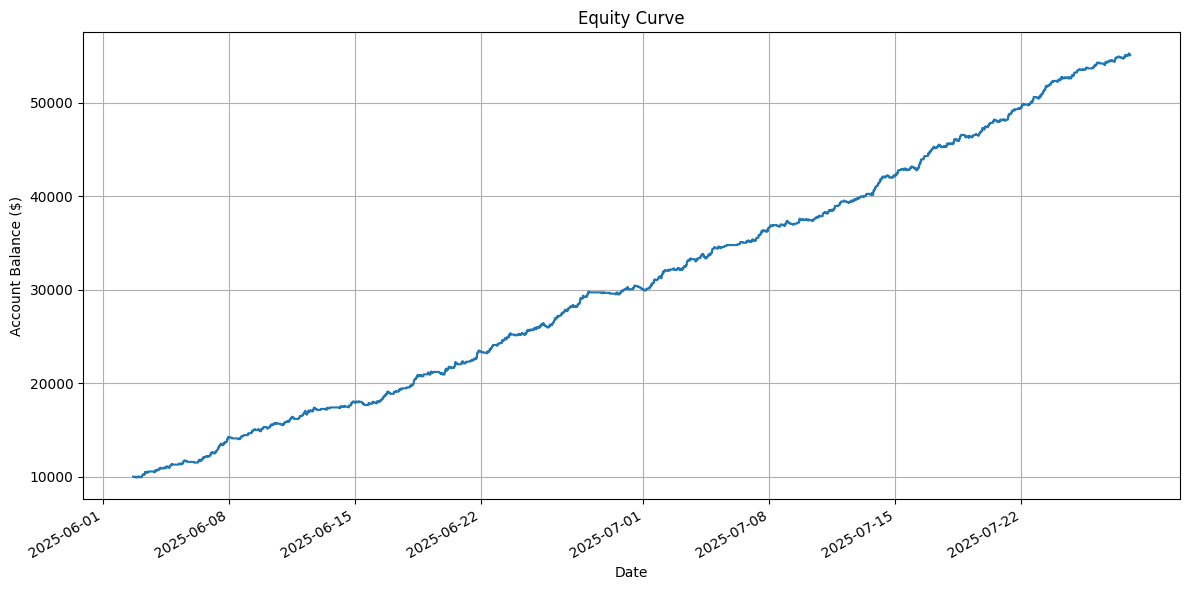

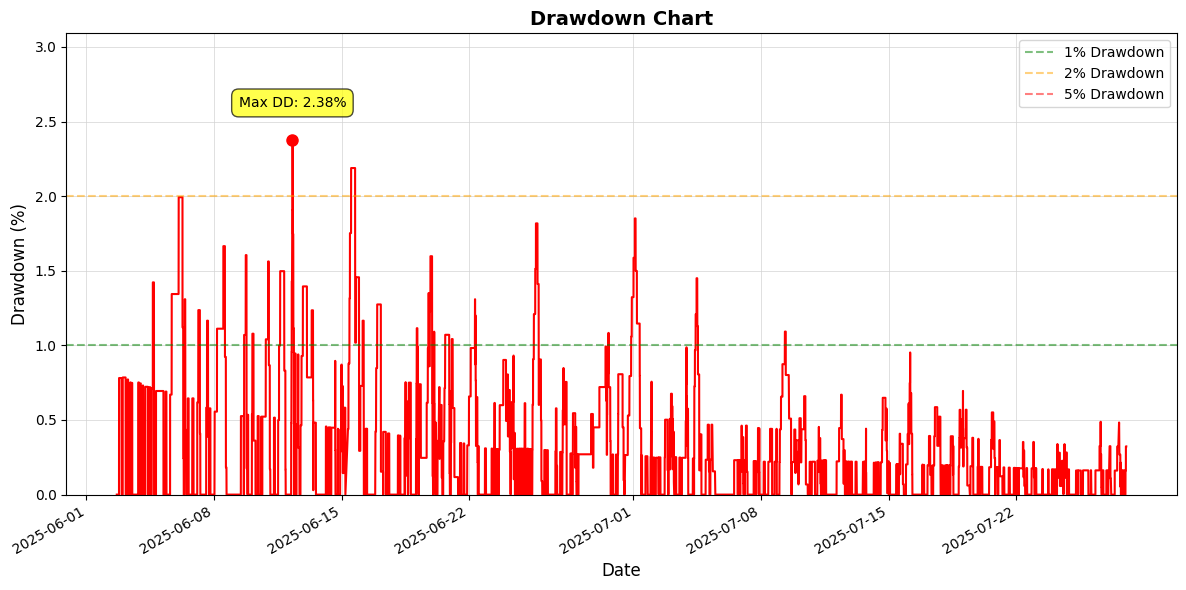

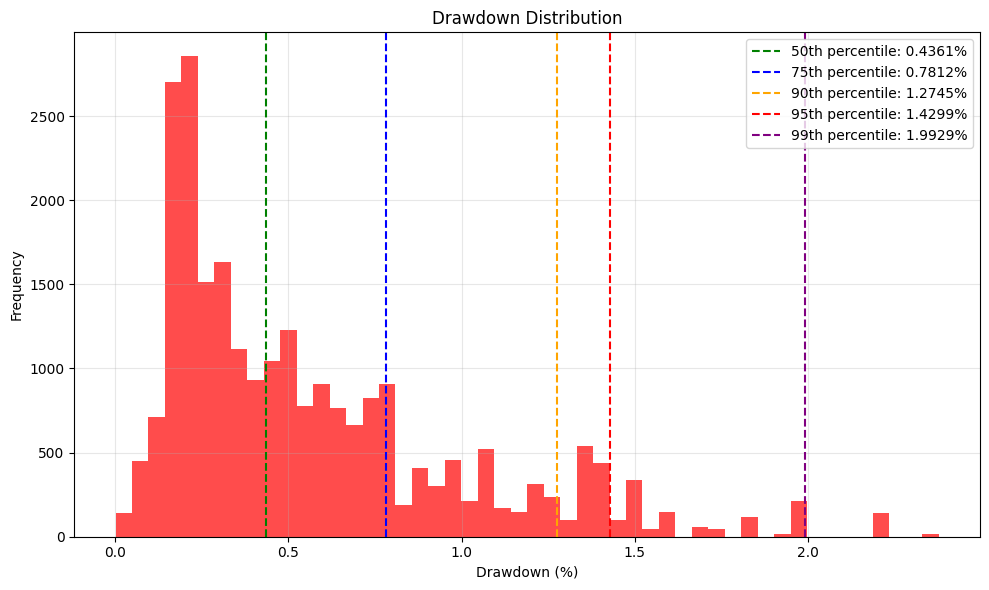

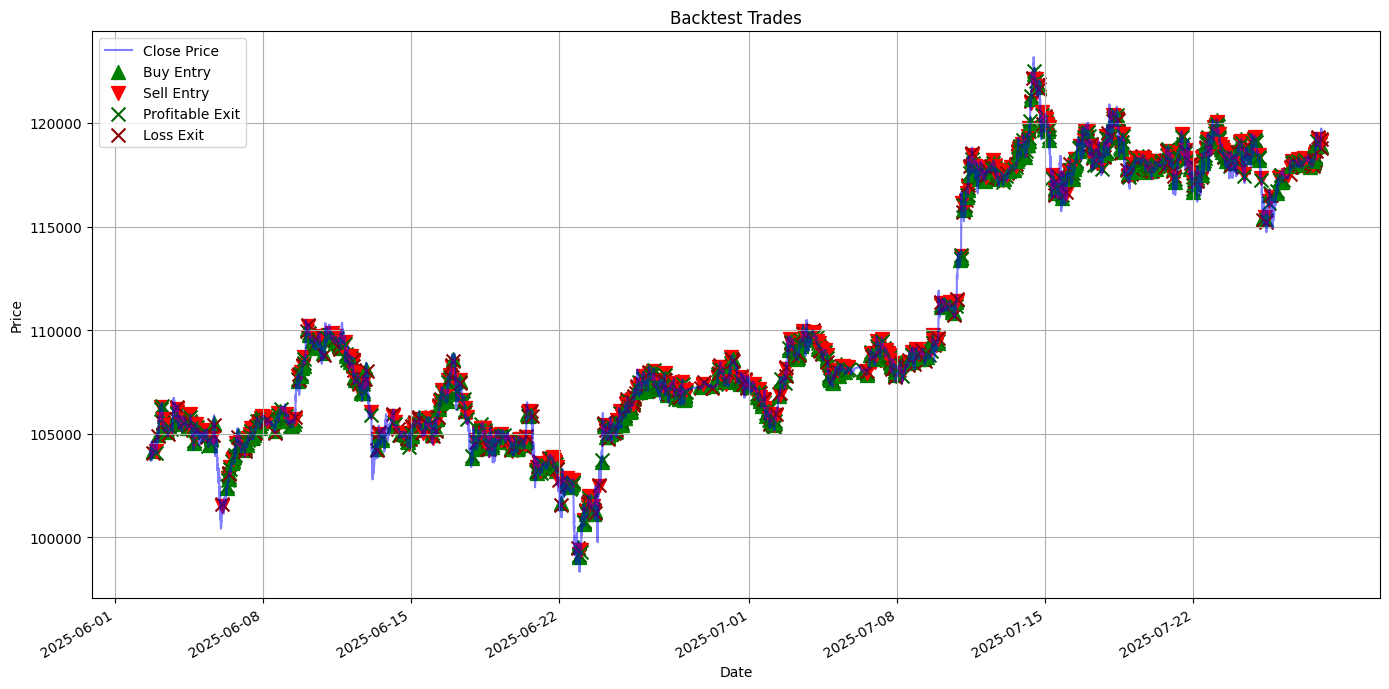

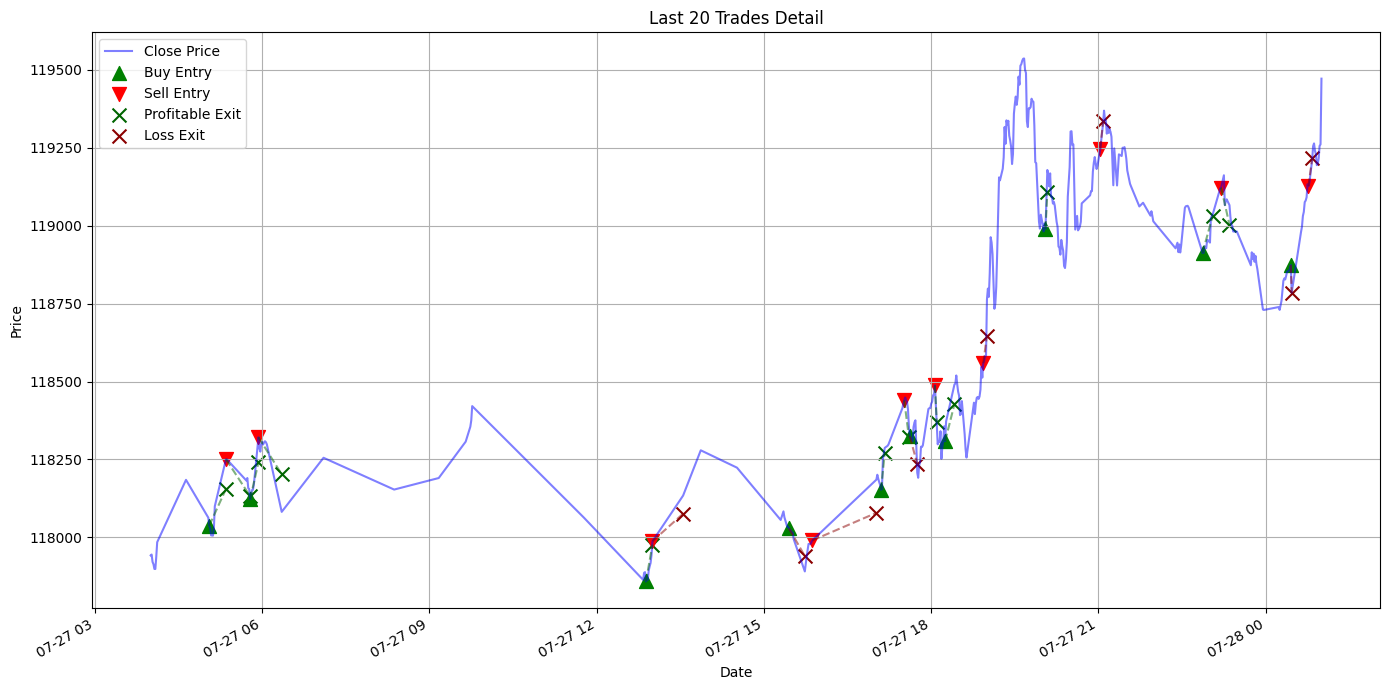

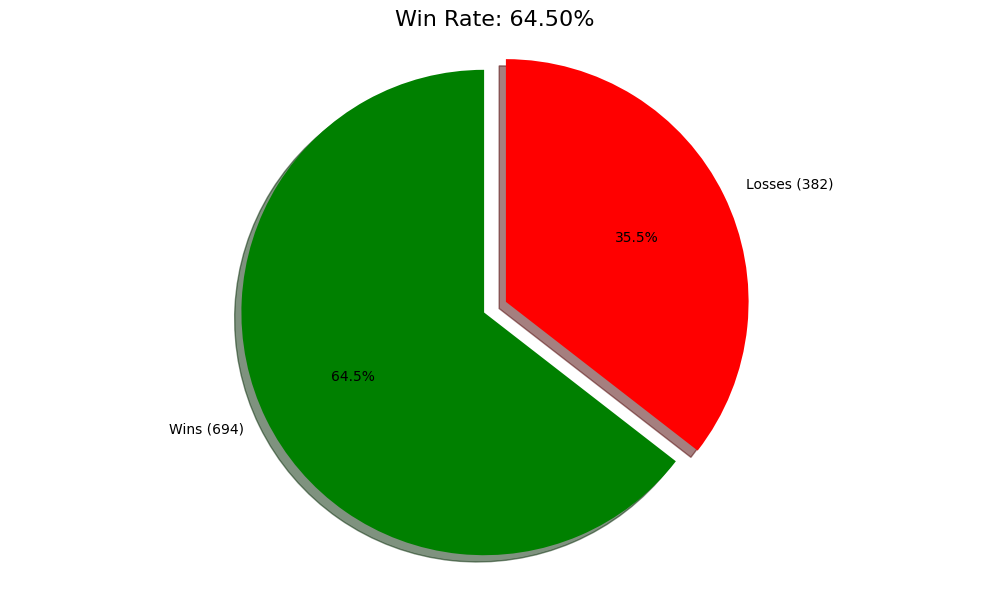

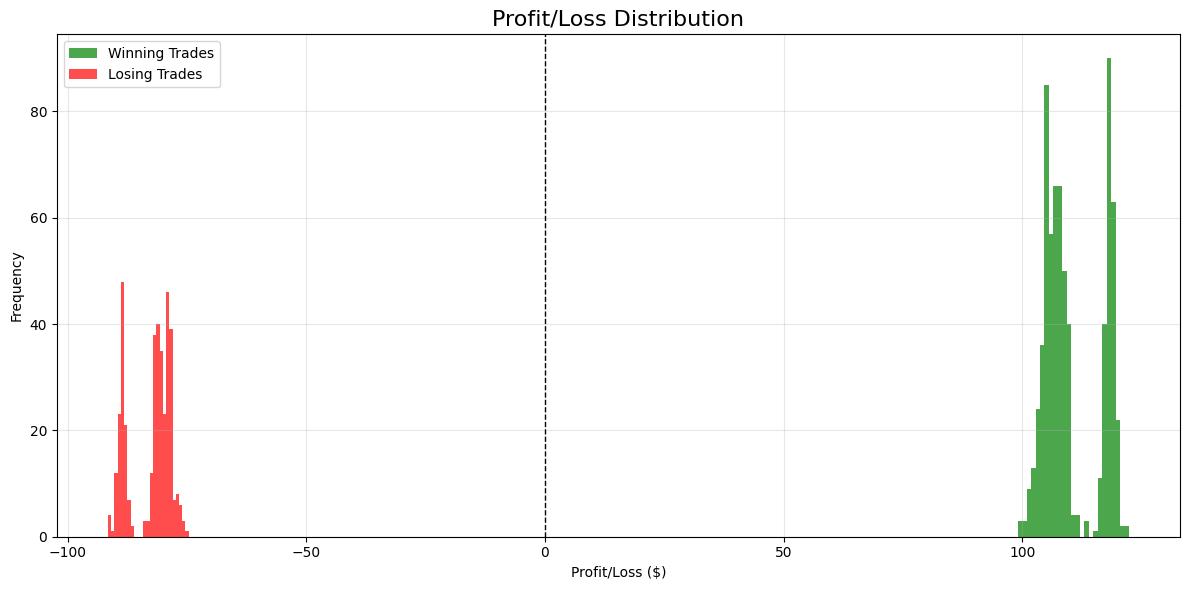

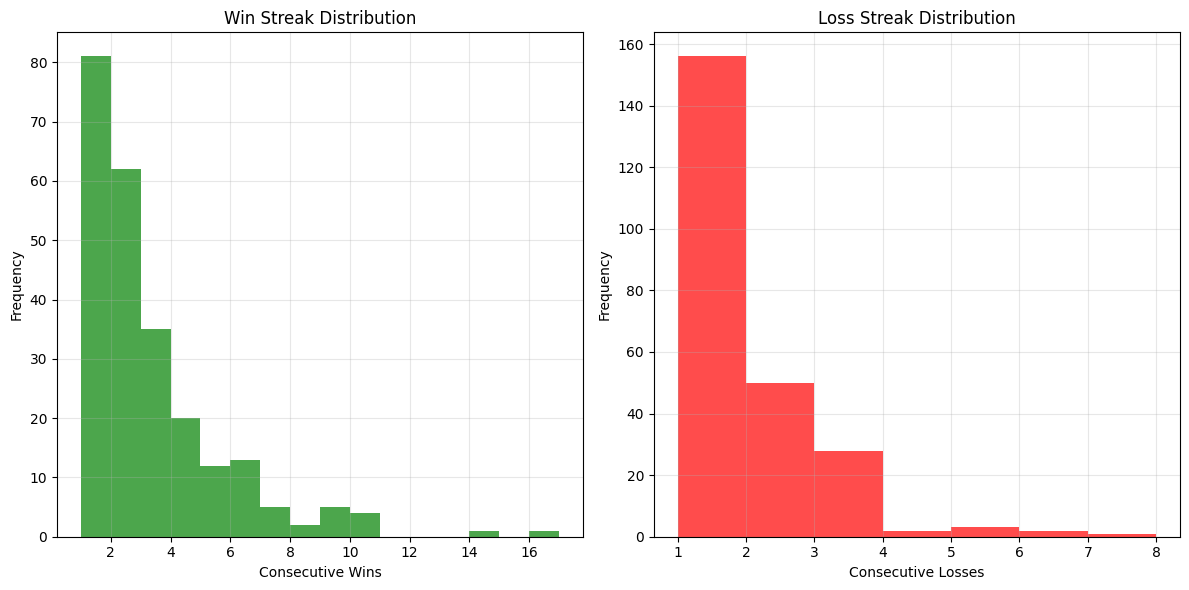

In [65]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import RobustScaler
import talib
import joblib
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Trading Parameters (from live.py)
SYMBOL = "BTCUSD"
SUPPORT_RESISTANCE_WINDOW = 200
SEQUENCE_LENGTH = 15
TP_PERCENT = 0.1  # Take profit as percentage (0.1%)
SL_PERCENT = 0.075  # Stop loss as percentage (0.075%)
CONFIDENCE_THRESHOLD = 0.65  # Minimum confidence to enter a trade
UNCERTAINTY_THRESHOLD = 0.015  # Maximum uncertainty to enter a trade
INITIAL_BALANCE = 10000  # Starting balance for backtest

# Bayesian Neural Network with LayerNorm (from live.py)
class BayesianMLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.ln2 = nn.LayerNorm(hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.ln3 = nn.LayerNorm(hidden_size // 4)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc4 = nn.Linear(hidden_size // 4, 2)
        
    def forward(self, x):
        x = self.dropout1(F.leaky_relu(self.ln1(self.fc1(x))))
        x = self.dropout2(F.leaky_relu(self.ln2(self.fc2(x))))
        x = self.dropout3(F.leaky_relu(self.ln3(self.fc3(x))))
        x = self.fc4(x)
        return x
    
    def predict_with_uncertainty(self, x, n_samples=50):
        """Monte Carlo Dropout for uncertainty estimation"""
        self.train()  # Set to training mode to enable dropout
        outputs = []
        for _ in range(n_samples):
            outputs.append(F.softmax(self(x), dim=1).unsqueeze(0))
        outputs = torch.cat(outputs, dim=0)
        mean = outputs.mean(dim=0)
        uncertainty = outputs.var(dim=0).sum(dim=1)
        return mean, uncertainty

class BacktestEngine:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.load_models()
        self.load_test_data()
        
        # Backtest state
        self.balance = INITIAL_BALANCE
        self.positions = []
        self.trades_history = []
        self.equity_curve = []
        
        print(f"Backtest Engine initialized on {self.device}")
        
    def load_models(self):
        """Load the trained models"""
        try:
            # Load metadata and models
            self.metadata = joblib.load("model_metadata.pkl")
            self.scaler = self.metadata['scaler']
            self.ridge_classifier = self.metadata['ridge_classifier']
            self.feature_columns = self.metadata['feature_columns']
            
            # Load neural network
            input_size = len(self.feature_columns) * 3 + len(self.feature_columns)  # Based on extract_features
            self.nn_model = BayesianMLP(input_size=input_size).to(self.device)
            self.nn_model.load_state_dict(torch.load("final_bayesian_model_weights.pth", map_location=self.device))
            
            print("Models loaded successfully")
        except Exception as e:
            print(f"Error loading models: {e}")
            import traceback
            traceback.print_exc()
            raise
    
    def load_test_data(self):
        """Load the test dataset from the original data"""
        # Load raw data
        raw_df = pd.read_csv("BTCUSD_M1_live_raw.csv")
        
        # Split raw data chronologically FIRST (as in model.py)
        total_raw_size = len(raw_df)
        train_raw_size = int(0.7 * total_raw_size)
        val_raw_size = int(0.15 * total_raw_size)
        
        # Get test data
        test_raw_df = raw_df.iloc[train_raw_size+val_raw_size:].copy().reset_index(drop=True)
        
        # Apply feature engineering and create labels
        self.test_df = self.apply_feature_engineering(test_raw_df)
        self.test_df = self.create_binary_labels(self.test_df, tp_target=0.001, tolerance_ratio=0.95)
        self.test_df = self.test_df.dropna().reset_index(drop=True)
        
        print(f"Test data loaded: {len(self.test_df)} rows")

    def apply_feature_engineering(self, df):
        """Apply feature engineering to raw data"""
        df = df.copy()
        # Momentum Indicators
        df['rsi_14'] = talib.RSI(df['close'], 14)
        df['rsi_5'] = talib.RSI(df['close'], 5)
        df['rsi_divergence'] = df['rsi_14'] - df['rsi_5']
        df['macd'], df['macd_signal'], df['macd_hist'] = talib.MACD(df['close'], 12, 26, 9)
        
        # Market regime features
        df['adx'] = talib.ADX(df['high'], df['low'], df['close'], 14)
        df['trending_market'] = df['adx'] > 25
        
        # Volatility metrics
        df['atr_14'] = talib.ATR(df['high'], df['low'], df['close'], 14)
        df['atr_volatility'] = df['atr_14'] / df['close']
        df['upper'], df['middle'], df['lower'] = talib.BBANDS(df['close'], timeperiod=20)
        df['bb_width'] = (df['upper'] - df['lower']) / df['middle']
        
        # Pattern recognition
        df['doji'] = ((df['close'] - df['open']).abs() / (df['high'] - df['low']) < 0.1).astype(float)
        df['engulfing'] = (
            ((df['close'] > df['open']) & 
            (df['open'].shift(1) > df['close'].shift(1)) & 
            (df['open'] <= df['close'].shift(1)) & 
            (df['close'] >= df['open'].shift(1)))
            |
            ((df['close'] < df['open']) & 
            (df['open'].shift(1) < df['close'].shift(1)) & 
            (df['open'] >= df['close'].shift(1)) & 
            (df['close'] <= df['open'].shift(1)))
        ).astype(float)
        
        # Relative position features
        df['close_to_high'] = (df['high'] - df['close']) / (df['high'] - df['low'])
        df['close_to_low'] = (df['close'] - df['low']) / (df['high'] - df['low'])
        
        # Moving average patterns
        df['ema_5'] = talib.EMA(df['close'], 5)
        df['ema_20'] = talib.EMA(df['close'], 20)
        df['ema_50'] = talib.EMA(df['close'], 50)
        df['ema_5_20_cross'] = ((df['ema_5'] > df['ema_20']) & 
                            (df['ema_5'].shift(1) <= df['ema_20'].shift(1))).astype(float)
        df['ema_20_50_cross'] = ((df['ema_20'] > df['ema_50']) & 
                            (df['ema_20'].shift(1) <= df['ema_50'].shift(1))).astype(float)
        
        # Volume analysis
        df['volume_ma'] = df['tick_volume'].rolling(20).mean()
        df['volume_ratio'] = df['tick_volume'] / df['volume_ma']
        df['volume_price_trend'] = df['close'] * df['tick_volume']
        df['obv'] = talib.OBV(df['close'], df['tick_volume'])
        df['obv_ma'] = talib.SMA(df['obv'], 20)
        df['obv_slope'] = df['obv'] - df['obv'].shift(5)
        
        # Supply and demand zones
        df['swing_high'] = df['high'].rolling(SUPPORT_RESISTANCE_WINDOW, center=False).max()
        df['swing_low'] = df['low'].rolling(SUPPORT_RESISTANCE_WINDOW, center=False).min()
        df['dist_to_high'] = (df['swing_high'] - df['close']) / df['close']
        df['dist_to_low'] = (df['close'] - df['swing_low']) / df['close']
        
        return df

    def create_binary_labels(self, df, tp_target=0.002, tolerance_ratio=0.9):
        """Create binary labels for price movements"""
        # Use global BAR_HORIZON
        BAR_HORIZON = 10
        df = df.copy()
        close = df['close'].values
        targets = []

        for i in range(len(close)):
            if i >= len(close) - BAR_HORIZON:
                targets.append(np.nan)
                continue

            current_price = close[i]
            future_prices = close[i+1:i+1+BAR_HORIZON]
            
            # Track first target hit
            label = np.nan
            for j, price in enumerate(future_prices):
                ret = (price - current_price) / current_price
                if ret >= tp_target * tolerance_ratio:
                    label = 1  # UP target hit
                    break
                elif ret <= -tp_target * tolerance_ratio:
                    label = -1  # DOWN target hit
                    break
                    
            targets.append(label)

        df['target'] = targets
        return df
        
    def predict_next_move(self, df, current_idx):
        """Predict the next market move for a specific index in the dataframe"""
        try:
            # Get relevant data up to current index
            df_current = df.iloc[:current_idx+1].copy()
            
            # Extract features
            features = df_current[self.feature_columns].values
            X = []
            
            # Only process if we have enough data
            if len(features) < SEQUENCE_LENGTH:
                return {"signal": None}
            
            # Create feature vector from the last SEQUENCE_LENGTH rows
            try:
                seq = features[-SEQUENCE_LENGTH:].astype(float)
                
                # Create feature vector
                feat_vec = []
                # Last observation
                feat_vec.extend(seq[-1])
                
                # Mean of sequence
                feat_vec.extend(np.mean(seq, axis=0))
                
                # Standard deviation
                std_vals = []
                for col in range(seq.shape[1]):
                    col_data = seq[:, col]
                    try:
                        std_val = np.std(col_data)
                        if np.isnan(std_val) or np.isinf(std_val):
                            std_val = 0.0
                    except:
                        std_val = 0.0
                    std_vals.append(std_val)
                feat_vec.extend(std_vals)
                
                # Trend (simple linear regression slope)
                for col in range(seq.shape[1]):
                    x = np.arange(SEQUENCE_LENGTH)
                    y_col = seq[:, col]
                    try:
                        if np.std(y_col) > 0:
                            slope = np.polyfit(x, y_col, 1)[0]
                        else:
                            slope = 0.0
                    except:
                        slope = 0.0
                    feat_vec.append(slope)
                
                # Convert to numpy array and check for invalid values
                feat_vec = np.array(feat_vec, dtype=float)
                if np.any(np.isnan(feat_vec)) or np.any(np.isinf(feat_vec)):
                    return {"signal": None}
                
                X_last = feat_vec.reshape(1, -1)
                
            except Exception as e:
                print(f"Error extracting features: {e}")
                return {"signal": None}
            
            # Scale features
            X_last_scaled = self.scaler.transform(X_last)
            
            # Ridge classifier prediction
            ridge_proba = self.ridge_classifier.predict_proba(X_last_scaled)[0, 1]
            
            # Neural network prediction
            X_tensor = torch.tensor(X_last_scaled, dtype=torch.float32).to(self.device)
            
            # Get prediction and uncertainty directly from the model
            with torch.no_grad():
                self.nn_model.eval()
                output = self.nn_model(X_tensor)
                nn_probs = F.softmax(output, dim=1)
                nn_proba = nn_probs[0, 1].item()
            
            # Get uncertainty using Monte Carlo Dropout
            probs, uncertainty = self.nn_model.predict_with_uncertainty(X_tensor)
            uncertainty_value = uncertainty[0].item()
            
            # Ensemble probabilities
            ensemble_proba = 0.4 * ridge_proba + 0.6 * nn_proba
            
            # Trading decision
            signal = None
            
            # Only generate signal if confidence is high enough and uncertainty is low enough
            if ensemble_proba > CONFIDENCE_THRESHOLD and uncertainty_value < UNCERTAINTY_THRESHOLD:
                signal = "BUY"
            elif (1 - ensemble_proba) > CONFIDENCE_THRESHOLD and uncertainty_value < UNCERTAINTY_THRESHOLD:
                signal = "SELL"
            
            return {
                "signal": signal,
                "ensemble_proba": ensemble_proba,
                "uncertainty": uncertainty_value,
                "ridge_proba": ridge_proba,
                "nn_proba": nn_proba,
                "current_price": df_current['close'].iloc[-1]
            }
            
        except Exception as e:
            print(f"Error in prediction: {e}")
            import traceback
            traceback.print_exc()
            return {"signal": None}
    
    def execute_trade(self, signal, current_idx, current_price):
        """Simulate trade execution in backtest"""
        if signal is None:
            return
        
        # Check if we already have positions
        if len(self.positions) >= 1:
            return
        
        # Calculate TP and SL based on percentage
        if signal == "BUY":
            sl_price = current_price * (1 - SL_PERCENT/100)
            tp_price = current_price * (1 + TP_PERCENT/100)
            position_type = "BUY"
        else:  # SELL
            sl_price = current_price * (1 + SL_PERCENT/100)
            tp_price = current_price * (1 - TP_PERCENT/100)
            position_type = "SELL"
        
        # Use fixed position size of 1 lot for PnL calculation
        position_size = 1.0
        
        # Open position
        position = {
            "type": position_type,
            "entry_price": current_price,
            "sl_price": sl_price,
            "tp_price": tp_price,
            "size": position_size,
            "entry_time": self.test_df.iloc[current_idx]['time'],
            "entry_idx": current_idx,
            "profit": 0.0,
            "profit_pips": 0.0,
            "profit_percent": 0.0
        }
        
        self.positions.append(position)
        
        return position
    
    def check_position_status(self, current_idx):
        """Check if any positions should be closed"""
        if not self.positions:
            return
        
        current_row = self.test_df.iloc[current_idx]
        current_time = current_row['time']
        current_high = current_row['high']
        current_low = current_row['low']
        current_close = current_row['close']
        
        closed_positions = []
        
        for position in self.positions:
            # Calculate current profit
            if position["type"] == "BUY":
                # Check if TP was hit during the candle
                if current_high >= position["tp_price"]:
                    # TP hit
                    exit_price = position["tp_price"]
                    profit = (exit_price - position["entry_price"]) * position["size"]
                    profit_pips = (exit_price - position["entry_price"]) * 10000  # Convert to pips for forex
                    profit_percent = ((exit_price / position["entry_price"]) - 1) * 100
                    
                    position["exit_price"] = exit_price
                    position["exit_reason"] = "TP"
                    position["exit_time"] = current_time
                    position["exit_idx"] = current_idx
                    position["profit"] = profit
                    position["profit_pips"] = profit_pips
                    position["profit_percent"] = profit_percent
                    
                    self.balance += profit
                    closed_positions.append(position)
                    
                # Check if SL was hit during the candle
                elif current_low <= position["sl_price"]:
                    # SL hit
                    exit_price = position["sl_price"]
                    loss = (exit_price - position["entry_price"]) * position["size"]
                    loss_pips = (exit_price - position["entry_price"]) * 10000  # Convert to pips for forex
                    loss_percent = ((exit_price / position["entry_price"]) - 1) * 100
                    
                    position["exit_price"] = exit_price
                    position["exit_reason"] = "SL"
                    position["exit_time"] = current_time
                    position["exit_idx"] = current_idx
                    position["profit"] = loss
                    position["profit_pips"] = loss_pips
                    position["profit_percent"] = loss_percent
                    
                    self.balance += loss
                    closed_positions.append(position)
                    
            else:  # SELL position
                # Check if TP was hit during the candle
                if current_low <= position["tp_price"]:
                    # TP hit
                    exit_price = position["tp_price"]
                    profit = (position["entry_price"] - exit_price) * position["size"]
                    profit_pips = (position["entry_price"] - exit_price) * 10000  # Convert to pips for forex
                    profit_percent = ((position["entry_price"] / exit_price) - 1) * 100
                    
                    position["exit_price"] = exit_price
                    position["exit_reason"] = "TP"
                    position["exit_time"] = current_time
                    position["exit_idx"] = current_idx
                    position["profit"] = profit
                    position["profit_pips"] = profit_pips
                    position["profit_percent"] = profit_percent
                    
                    self.balance += profit
                    closed_positions.append(position)
                    
                # Check if SL was hit during the candle
                elif current_high >= position["sl_price"]:
                    # SL hit
                    exit_price = position["sl_price"]
                    loss = (position["entry_price"] - exit_price) * position["size"]
                    loss_pips = (position["entry_price"] - exit_price) * 10000  # Convert to pips for forex
                    loss_percent = ((position["entry_price"] / exit_price) - 1) * 100
                    
                    position["exit_price"] = exit_price
                    position["exit_reason"] = "SL"
                    position["exit_time"] = current_time
                    position["exit_idx"] = current_idx
                    position["profit"] = loss
                    position["profit_pips"] = loss_pips
                    position["profit_percent"] = loss_percent
                    
                    self.balance += loss
                    closed_positions.append(position)
        
        # Remove closed positions
        for position in closed_positions:
            self.positions.remove(position)
            self.trades_history.append(position)

    def run_backtest(self):
        """Run the backtest over the test dataset"""
        print(f"Starting backtest with initial balance: ${INITIAL_BALANCE}")
        print(f"TP: {TP_PERCENT}%, SL: {SL_PERCENT}%")
        print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}, Uncertainty threshold: {UNCERTAINTY_THRESHOLD}")
        
        # Initialize tracking variables
        self.equity_curve = [self.balance]
        last_signal = None
        min_bars_between_trades = 5
        last_trade_idx = -min_bars_between_trades
        
        # Loop through each bar in the test dataset
        for idx in range(SEQUENCE_LENGTH, len(self.test_df)):
            # Check existing positions first
            self.check_position_status(idx)
            
            # Record equity for this bar
            self.equity_curve.append(self.balance)
            
            # Only check for new trades if we don't have any open positions
            if not self.positions and idx - last_trade_idx >= min_bars_between_trades:
                # Get prediction
                prediction = self.predict_next_move(self.test_df, idx)
                signal = prediction.get("signal")
                current_price = self.test_df.iloc[idx]['close']
                
                # Execute trade if signal is different from last signal
                if signal is not None and signal != last_signal:
                    position = self.execute_trade(signal, idx, current_price)
                    if position:
                        last_signal = signal
                        last_trade_idx = idx
                        print(f"Bar {idx}: Opened {signal} position at {current_price}")
        
        # Close any remaining positions at the last price
        if self.positions:
            last_price = self.test_df.iloc[-1]['close']
            for position in self.positions:
                if position["type"] == "BUY":
                    profit = (last_price - position["entry_price"]) * position["size"]
                else:  # SELL
                    profit = (position["entry_price"] - last_price) * position["size"]
                
                position["exit_price"] = last_price
                position["exit_reason"] = "END"
                position["exit_time"] = self.test_df.iloc[-1]['time']
                position["exit_idx"] = len(self.test_df) - 1
                position["profit"] = profit
                self.balance += profit
                self.trades_history.append(position)
            
            self.positions = []
            self.equity_curve.append(self.balance)
        
        # Calculate performance metrics
        self.calculate_performance()
        
    def calculate_performance(self):
        """Calculate and display backtest performance metrics"""
        # Basic metrics
        total_trades = len(self.trades_history)
        if total_trades == 0:
            print("No trades were executed during the backtest.")
            return
        
        profitable_trades = sum(1 for trade in self.trades_history if trade["profit"] > 0)
        losing_trades = total_trades - profitable_trades
        win_rate = profitable_trades / total_trades * 100
        
        total_profit = sum(trade["profit"] for trade in self.trades_history if trade["profit"] > 0)
        total_loss = sum(trade["profit"] for trade in self.trades_history if trade["profit"] <= 0)
        
        # Avoid division by zero
        profit_factor = abs(total_profit / total_loss) if total_loss != 0 else float('inf')
        
        # Calculate returns
        initial_balance = INITIAL_BALANCE
        final_balance = self.balance
        net_profit = final_balance - initial_balance
        percent_return = (net_profit / initial_balance) * 100
        
        # Improved drawdown calculation
        # 1. Calculate trade-by-trade drawdown
        running_balance = initial_balance
        peak_balance = initial_balance
        drawdowns = []
        drawdown_periods = []
        current_drawdown_start = None
        
        # Create a list of all equity changes (including both trades and interim equity points)
        equity_changes = []
        
        # Add initial balance
        equity_changes.append({"time": self.test_df.iloc[0]['time'], "balance": initial_balance, "type": "initial"})
        
        # Add all trades
        for trade in self.trades_history:
            equity_changes.append({
                "time": trade['exit_time'],
                "balance": running_balance + trade['profit'],
                "profit": trade['profit'],
                "type": "trade"
            })
            running_balance += trade['profit']
        
        # Sort by time
        equity_changes.sort(key=lambda x: pd.to_datetime(x['time']))
        
        # Calculate drawdowns
        running_balance = initial_balance
        peak_balance = initial_balance
        max_drawdown = 0
        max_drawdown_start = None
        max_drawdown_end = None
        in_drawdown = False
        
        for i, change in enumerate(equity_changes):
            if i == 0:  # Skip initial balance
                continue
                
            running_balance = change['balance']
            
            if running_balance > peak_balance:
                # New peak
                peak_balance = running_balance
                if in_drawdown:
                    in_drawdown = False
            elif running_balance < peak_balance:
                # Potential drawdown
                current_drawdown = (peak_balance - running_balance) / peak_balance * 100
                
                if not in_drawdown:
                    # Start of a new drawdown
                    in_drawdown = True
                    drawdown_start = equity_changes[i-1]['time']
                
                if current_drawdown > max_drawdown:
                    max_drawdown = current_drawdown
                    max_drawdown_start = drawdown_start
                    max_drawdown_end = change['time']
                    
                drawdowns.append(current_drawdown)
        
        # If no drawdowns were found, set max_drawdown to 0
        if not drawdowns:
            max_drawdown = 0
        
        # Also calculate the traditional way as a backup
        equity_array = np.array(self.equity_curve)
        max_equity = np.maximum.accumulate(equity_array)
        traditional_drawdown = (max_equity - equity_array) / max_equity * 100
        traditional_max_drawdown = np.max(traditional_drawdown) if len(traditional_drawdown) > 0 else 0
        
        # Use the larger of the two calculations to be conservative
        max_drawdown = max(max_drawdown, traditional_max_drawdown)
        
        # Print results
        print("\n===== BACKTEST RESULTS =====")
        print(f"Initial Balance: ${initial_balance:.2f}")
        print(f"Final Balance: ${final_balance:.2f}")
        print(f"Net Profit: ${net_profit:.2f} ({percent_return:.2f}%)")
        print(f"Total Trades: {total_trades}")
        print(f"Profitable Trades: {profitable_trades} ({win_rate:.2f}%)")
        print(f"Losing Trades: {losing_trades} ({100-win_rate:.2f}%)")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Maximum Drawdown: {max_drawdown:.4f}%")
        
        if max_drawdown_start and max_drawdown_end:
            start_date = pd.to_datetime(max_drawdown_start).strftime('%Y-%m-%d %H:%M')
            end_date = pd.to_datetime(max_drawdown_end).strftime('%Y-%m-%d %H:%M')
            print(f"Max Drawdown Period: {start_date} to {end_date}")
        
        # Plot equity curve
        plt.figure(figsize=(12, 6))
        
        # Create a list of dates for the equity curve
        equity_dates = pd.to_datetime(self.test_df['time'].iloc[:len(self.equity_curve)])
        
        plt.plot(equity_dates, self.equity_curve)
        plt.title('Equity Curve')
        plt.xlabel('Date')
        plt.ylabel('Account Balance ($)')
        plt.grid(True)
        plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels
        plt.tight_layout()
        plt.savefig('backtest_equity_curve.png')
        print("Equity curve saved as 'backtest_equity_curve.png'")
        
        # Plot drawdown chart
        if len(self.equity_curve) > 1:
            plt.figure(figsize=(12, 6))
            
            # Create a list of dates for the drawdown chart
            drawdown_dates = pd.to_datetime(self.test_df['time'].iloc[:len(traditional_drawdown)])
            
            # Plot the drawdown line
            plt.plot(drawdown_dates, traditional_drawdown, color='red', linewidth=1.5)
            
            # Add grid with light gray color
            plt.grid(True, color='lightgray', linestyle='-', linewidth=0.5)
            
            # Add horizontal lines for reference
            plt.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='1% Drawdown')
            plt.axhline(y=2, color='orange', linestyle='--', alpha=0.5, label='2% Drawdown')
            plt.axhline(y=5, color='red', linestyle='--', alpha=0.5, label='5% Drawdown')
            
            # Set y-axis limit to make sure annotation is visible
            plt.ylim(0, max(traditional_max_drawdown * 1.3, 1))
            
            # Annotate maximum drawdown - using a different approach
            if traditional_max_drawdown > 0:
                max_dd_idx = np.argmax(traditional_drawdown)
                max_dd_date = drawdown_dates[max_dd_idx]
                
                # Add a marker at the max drawdown point
                plt.plot(max_dd_date, traditional_max_drawdown, 'ro', markersize=8)
                
                # Add a text label above the max drawdown point
                plt.text(max_dd_date, traditional_max_drawdown + 0.2, 
                        f'Max DD: {traditional_max_drawdown:.2f}%',
                        horizontalalignment='center',
                        verticalalignment='bottom',
                        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))
            
            plt.title('Drawdown Chart', fontsize=14, fontweight='bold')
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Drawdown (%)', fontsize=12)
            plt.legend()
            plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels
            plt.tight_layout()
            plt.savefig('drawdown_chart.png', dpi=300)
            print("Drawdown chart saved as 'drawdown_chart.png'")
            
            # Create a separate chart showing drawdown distribution
            plt.figure(figsize=(10, 6))
            
            # Calculate drawdown distribution
            drawdown_values = [d for d in traditional_drawdown if d > 0]
            if drawdown_values:
                plt.hist(drawdown_values, bins=50, color='red', alpha=0.7)
                plt.title('Drawdown Distribution')
                plt.xlabel('Drawdown (%)')
                plt.ylabel('Frequency')
                plt.grid(True, alpha=0.3)
                
                # Add vertical lines for key percentiles
                percentiles = [50, 75, 90, 95, 99]
                colors = ['green', 'blue', 'orange', 'red', 'purple']
                
                for p, c in zip(percentiles, colors):
                    value = np.percentile(drawdown_values, p)
                    plt.axvline(x=value, color=c, linestyle='--', 
                                label=f'{p}th percentile: {value:.4f}%')
                
                plt.legend()
                plt.tight_layout()
                plt.savefig('drawdown_distribution.png', dpi=300)
                print("Drawdown distribution chart saved as 'drawdown_distribution.png'")
        
        # Plot trades on price chart
        self.plot_trades()
        
        # Print detailed trade information
        self.print_trade_details()
        
    def plot_trades(self):
        """Plot trades on the price chart with annotations"""
        plt.figure(figsize=(14, 7))
        
        # Plot price
        dates = pd.to_datetime(self.test_df['time'])
        plt.plot(dates, self.test_df['close'], label='Close Price', color='blue', alpha=0.5)
        
        # Plot trades with annotations for profit/loss
        for i, trade in enumerate(self.trades_history):
            entry_idx = trade['entry_idx']
            exit_idx = trade['exit_idx']
            entry_price = trade['entry_price']
            exit_price = trade['exit_price']
            profit = trade['profit']
            
            entry_date = pd.to_datetime(trade['entry_time'])
            exit_date = pd.to_datetime(trade['exit_time'])
            
            # Plot entry point
            marker = '^' if trade['type'] == 'BUY' else 'v'
            color = 'green' if trade['type'] == 'BUY' else 'red'
            plt.scatter(entry_date, entry_price, color=color, marker=marker, s=100)
            
            # Plot exit point
            exit_color = 'darkgreen' if profit > 0 else 'darkred'
            plt.scatter(exit_date, exit_price, color=exit_color, marker='x', s=100)
            
            # Connect entry and exit with a line
            plt.plot([entry_date, exit_date], [entry_price, exit_price], 
                     color=exit_color, linestyle='--', alpha=0.5)
            
            # Remove profit/loss annotation
        
        # Add legend
        plt.scatter([], [], color='green', marker='^', s=100, label='Buy Entry')
        plt.scatter([], [], color='red', marker='v', s=100, label='Sell Entry')
        plt.scatter([], [], color='darkgreen', marker='x', s=100, label='Profitable Exit')
        plt.scatter([], [], color='darkred', marker='x', s=100, label='Loss Exit')
        
        plt.title('Backtest Trades')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels
        plt.tight_layout()
        plt.savefig('backtest_trades.png')
        print("Trades chart saved as 'backtest_trades.png'")
        
        # Create a separate chart showing just a subset of trades for better visibility
        if len(self.trades_history) > 20:
            # Plot the last 20 trades for clearer visualization
            plt.figure(figsize=(14, 7))
            
            # Find index range for last 20 trades
            last_trades = self.trades_history[-20:]
            start_idx = last_trades[0]['entry_idx'] - 10  # Add some bars before first trade
            end_idx = last_trades[-1]['exit_idx'] + 10    # Add some bars after last trade
            
            # Ensure indices are within range
            start_idx = max(0, start_idx)
            end_idx = min(len(self.test_df) - 1, end_idx)
            
            # Plot price for this range with dates
            date_subset = pd.to_datetime(self.test_df['time'].iloc[start_idx:end_idx + 1])
            plt.plot(date_subset, 
                     self.test_df['close'].iloc[start_idx:end_idx + 1], 
                     label='Close Price', color='blue', alpha=0.5)
            
            # Plot the trades in this range
            for trade in last_trades:
                entry_idx = trade['entry_idx']
                exit_idx = trade['exit_idx']
                entry_price = trade['entry_price']
                exit_price = trade['exit_price']
                profit = trade['profit']
                
                entry_date = pd.to_datetime(trade['entry_time'])
                exit_date = pd.to_datetime(trade['exit_time'])
                
                # Plot entry point
                marker = '^' if trade['type'] == 'BUY' else 'v'
                color = 'green' if trade['type'] == 'BUY' else 'red'
                plt.scatter(entry_date, entry_price, color=color, marker=marker, s=100)
                
                # Plot exit point
                exit_color = 'darkgreen' if profit > 0 else 'darkred'
                plt.scatter(exit_date, exit_price, color=exit_color, marker='x', s=100)
                
                # Connect entry and exit with a line
                plt.plot([entry_date, exit_date], [entry_price, exit_price], 
                         color=exit_color, linestyle='--', alpha=0.5)
                
                # Remove profit/loss annotation
            
            # Add legend
            plt.scatter([], [], color='green', marker='^', s=100, label='Buy Entry')
            plt.scatter([], [], color='red', marker='v', s=100, label='Sell Entry')
            plt.scatter([], [], color='darkgreen', marker='x', s=100, label='Profitable Exit')
            plt.scatter([], [], color='darkred', marker='x', s=100, label='Loss Exit')
            
            plt.title('Last 20 Trades Detail')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.gcf().autofmt_xdate()  # Auto-format the x-axis date labels
            plt.tight_layout()
            plt.savefig('backtest_recent_trades.png')
            print("Recent trades chart saved as 'backtest_recent_trades.png'")
        
    def print_trade_details(self):
        """Print detailed information about each trade"""
        print("\n===== TRADE DETAILS =====")
        print(f"{'#':<4} {'Type':<6} {'Entry Time':<20} {'Exit Time':<20} {'Entry':<10} {'Exit':<10} {'P/L':<10} {'P/L %':<10} {'Reason':<6}")
        print("-" * 100)
        
        # Calculate running balance and drawdown for each trade
        running_balance = INITIAL_BALANCE
        peak_balance = INITIAL_BALANCE
        trade_data = []
        
        for i, trade in enumerate(self.trades_history):
            entry_time = pd.to_datetime(trade['entry_time']).strftime('%Y-%m-%d %H:%M')
            exit_time = pd.to_datetime(trade['exit_time']).strftime('%Y-%m-%d %H:%M')
            
            # Update running balance
            running_balance += trade['profit']
            
            # Calculate drawdown
            if running_balance > peak_balance:
                peak_balance = running_balance
                drawdown = 0.0
            else:
                drawdown = (peak_balance - running_balance) / peak_balance * 100 if peak_balance > 0 else 0.0
            
            # Store trade data with drawdown information
            trade_data.append({
                **trade,
                'trade_number': i+1,
                'running_balance': running_balance,
                'drawdown': drawdown
            })
            
            print(f"{i+1:<4} {trade['type']:<6} {entry_time:<20} {exit_time:<20} "
                  f"{trade['entry_price']:<10.5f} {trade['exit_price']:<10.5f} "
                  f"${trade['profit']:<9.2f} {trade['profit_percent']:<10.2f}% {trade['exit_reason']:<6}")
        
        # Save trades to CSV with enhanced information
        trades_df = pd.DataFrame(trade_data)
        trades_df.to_csv('backtest_trades.csv', index=False)
        print("\nTrade details saved to 'backtest_trades.csv'")
        
        # Calculate PnL statistics
        total_pnl = sum(trade['profit'] for trade in self.trades_history)
        avg_pnl = total_pnl / len(self.trades_history) if self.trades_history else 0
        avg_win = sum(trade['profit'] for trade in self.trades_history if trade['profit'] > 0) / sum(1 for trade in self.trades_history if trade['profit'] > 0) if sum(1 for trade in self.trades_history if trade['profit'] > 0) > 0 else 0
        avg_loss = sum(trade['profit'] for trade in self.trades_history if trade['profit'] <= 0) / sum(1 for trade in self.trades_history if trade['profit'] <= 0) if sum(1 for trade in self.trades_history if trade['profit'] <= 0) > 0 else 0
        
        # Calculate win rate
        total_trades = len(self.trades_history)
        winning_trades = sum(1 for trade in self.trades_history if trade['profit'] > 0)
        losing_trades = sum(1 for trade in self.trades_history if trade['profit'] <= 0)
        win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
        
        # Calculate percentage statistics
        total_percent = sum(trade['profit_percent'] for trade in self.trades_history)
        avg_percent = total_percent / len(self.trades_history) if self.trades_history else 0
        avg_win_percent = sum(trade['profit_percent'] for trade in self.trades_history if trade['profit'] > 0) / sum(1 for trade in self.trades_history if trade['profit'] > 0) if sum(1 for trade in self.trades_history if trade['profit'] > 0) > 0 else 0
        avg_loss_percent = sum(trade['profit_percent'] for trade in self.trades_history if trade['profit'] <= 0) / sum(1 for trade in self.trades_history if trade['profit'] <= 0) if sum(1 for trade in self.trades_history if trade['profit'] <= 0) > 0 else 0
        
        print("\n===== PNL STATISTICS =====")
        print(f"Win Rate: {win_rate:.2f}% ({winning_trades}/{total_trades})")
        print(f"Total PnL: ${total_pnl:.2f}")
        print(f"Average PnL per Trade: ${avg_pnl:.2f}")
        print(f"Average Win: ${avg_win:.2f}")
        print(f"Average Loss: ${avg_loss:.2f}")
        print(f"Average Win/Loss Ratio: {abs(avg_win/avg_loss):.2f}" if avg_loss != 0 else "Average Win/Loss Ratio: ∞")
        
        print("\n===== PERCENTAGE STATISTICS =====")
        print(f"Total Percentage Gain/Loss: {total_percent:.2f}%")
        print(f"Average Percentage per Trade: {avg_percent:.2f}%")
        print(f"Average Win Percentage: {avg_win_percent:.2f}%")
        print(f"Average Loss Percentage: {avg_loss_percent:.2f}%")
        
        # Create win rate visualization
        plt.figure(figsize=(10, 6))
        
        # Create pie chart of win/loss ratio
        labels = [f'Wins ({winning_trades})', f'Losses ({losing_trades})']
        sizes = [winning_trades, losing_trades]
        colors = ['green', 'red']
        explode = (0.1, 0)  # explode the 1st slice (Wins)
        
        plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                shadow=True, startangle=90)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        plt.title(f'Win Rate: {win_rate:.2f}%', fontsize=16)
        plt.tight_layout()
        plt.savefig('win_rate_chart.png', dpi=300)
        print("Win rate chart saved as 'win_rate_chart.png'")
        
        # Create win/loss distribution chart
        plt.figure(figsize=(12, 6))
        
        # Extract profit values
        profits = [trade['profit'] for trade in self.trades_history]
        winning_profits = [p for p in profits if p > 0]
        losing_profits = [p for p in profits if p <= 0]
        
        # Create separate histograms for wins and losses
        plt.hist(winning_profits, bins=25, color='green', alpha=0.7, label='Winning Trades')
        plt.hist(losing_profits, bins=25, color='red', alpha=0.7, label='Losing Trades')
        
        plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
        plt.title('Profit/Loss Distribution', fontsize=16)
        plt.xlabel('Profit/Loss ($)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('profit_distribution.png', dpi=300)
        print("Profit distribution chart saved as 'profit_distribution.png'")
        
        # Analyze winning and losing streaks
        if self.trades_history:
            # Create a list of trade results (1 for win, 0 for loss)
            results = [1 if trade['profit'] > 0 else 0 for trade in self.trades_history]
            
            # Calculate streaks
            win_streaks = []
            loss_streaks = []
            current_streak = 1
            
            for i in range(1, len(results)):
                if results[i] == results[i-1]:
                    current_streak += 1
                else:
                    if results[i-1] == 1:  # End of win streak
                        win_streaks.append(current_streak)
                    else:  # End of loss streak
                        loss_streaks.append(current_streak)
                    current_streak = 1
            
            # Add the last streak
            if results[-1] == 1:
                win_streaks.append(current_streak)
            else:
                loss_streaks.append(current_streak)
            
            # Calculate streak statistics
            max_win_streak = max(win_streaks) if win_streaks else 0
            max_loss_streak = max(loss_streaks) if loss_streaks else 0
            avg_win_streak = sum(win_streaks) / len(win_streaks) if win_streaks else 0
            avg_loss_streak = sum(loss_streaks) / len(loss_streaks) if loss_streaks else 0
            
            print("\n===== STREAK ANALYSIS =====")
            print(f"Maximum Consecutive Wins: {max_win_streak}")
            print(f"Maximum Consecutive Losses: {max_loss_streak}")
            print(f"Average Win Streak: {avg_win_streak:.2f}")
            print(f"Average Loss Streak: {avg_loss_streak:.2f}")
            
            # Plot streak distribution
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.hist(win_streaks, bins=range(1, max(max_win_streak, 2) + 2), alpha=0.7, color='green')
            plt.title('Win Streak Distribution')
            plt.xlabel('Consecutive Wins')
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 2, 2)
            plt.hist(loss_streaks, bins=range(1, max(max_loss_streak, 2) + 2), alpha=0.7, color='red')
            plt.title('Loss Streak Distribution')
            plt.xlabel('Consecutive Losses')
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig('streak_analysis.png', dpi=300)
            print("Streak analysis chart saved as 'streak_analysis.png'")
            
            # Add streak information to the summary data
            summary_data = {
                'Initial Balance': INITIAL_BALANCE,
                'Final Balance': running_balance,
                'Net Profit': running_balance - INITIAL_BALANCE,
                'Return %': ((running_balance - INITIAL_BALANCE) / INITIAL_BALANCE) * 100,
                'Total Trades': len(self.trades_history),
                'Winning Trades': winning_trades,
                'Losing Trades': losing_trades,
                'Win Rate %': win_rate,
                'Max Win Streak': max_win_streak,
                'Max Loss Streak': max_loss_streak,
                'Avg Win Streak': avg_win_streak,
                'Avg Loss Streak': avg_loss_streak,
                'Max Drawdown %': max(t['drawdown'] for t in trade_data) if trade_data else 0,
                'Profit Factor': abs(sum(t['profit'] for t in self.trades_history if t['profit'] > 0) / 
                                sum(t['profit'] for t in self.trades_history if t['profit'] <= 0)) if sum(t['profit'] for t in self.trades_history if t['profit'] <= 0) != 0 else float('inf'),
                'Average Win': avg_win,
                'Average Loss': avg_loss,
                'Average Win %': avg_win_percent,
                'Average Loss %': avg_loss_percent,
                'Average Win/Loss Ratio': abs(avg_win/avg_loss) if avg_loss != 0 else float('inf'),
                'Total PnL': total_pnl,
                'Average PnL per Trade': avg_pnl,
                'Total Percentage Gain/Loss': total_percent,
                'Average Percentage per Trade': avg_percent,
            }
        else:
            summary_data = {
                'Initial Balance': INITIAL_BALANCE,
                'Final Balance': INITIAL_BALANCE,
                'Net Profit': 0,
                'Return %': 0,
                'Total Trades': 0,
                'Winning Trades': 0,
                'Losing Trades': 0,
                'Win Rate %': 0,
                'Max Drawdown %': 0,
                'Profit Factor': 0,
                'Average Win': 0,
                'Average Loss': 0,
                'Average Win %': 0,
                'Average Loss %': 0,
                'Average Win/Loss Ratio': 0,
                'Total PnL': 0,
                'Average PnL per Trade': 0,
                'Total Percentage Gain/Loss': 0,
                'Average Percentage per Trade': 0,
            }
        
        pd.DataFrame([summary_data]).to_csv('backtest_summary.csv', index=False)
        print("\nSummary metrics saved to 'backtest_summary.csv'")

if __name__ == "__main__":
    backtest = BacktestEngine()
    backtest.run_backtest()

Live trading

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import RobustScaler
import talib
import joblib
import os
import time
from datetime import datetime, timedelta
import warnings
import MetaTrader5 as mt5

# Suppress warnings
warnings.filterwarnings('ignore')

# MT5 Configuration
MT5_CONFIG = {
    "path": r"C:\Program Files\MetaTrader 5\terminal64.exe",
    "login": account,
    "password": password,
    "server": server,
}
# Trading Parameters
SYMBOL = "BTCUSD"
TIMEFRAME = mt5.TIMEFRAME_M1  # 1-minute timeframe
SUPPORT_RESISTANCE_WINDOW = 200
SEQUENCE_LENGTH = 15
TP_PERCENT = 0.1  # Take profit as percentage (0.1%)
SL_PERCENT = 0.075  # Stop loss as percentage (0.075%)
MAX_POSITIONS = 1  # Maximum number of open positions
RISK_PER_TRADE = 0.2  # 2% risk per trade
CONFIDENCE_THRESHOLD = 0.65  # Minimum confidence to enter a trade
UNCERTAINTY_THRESHOLD = 0.015  # Maximum uncertainty to enter a trade

# Position sizing options
USE_RISK_BASED_SIZING = False  # Set to False for manual sizing
MANUAL_LOT_SIZE = 0.3  # Only used if USE_RISK_BASED_SIZING is False

# Spread check
MAX_SPREAD_PERCENT = 0.05  # Maximum acceptable spread as percentage

# Trailing Stop Loss parameters
USE_TRAILING_STOP = True  # Enable/disable trailing stop
TRAILING_START_PERCENT = 0.05  # Start trailing when profit reaches this percentage
TRAILING_STEP_PERCENT = 0.03  # Move SL by this percentage when trailing
TRAILING_CHECK_SECONDS = 1  # How often to check for trailing stop updates

# Bayesian Neural Network with LayerNorm
class BayesianMLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.ln2 = nn.LayerNorm(hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.ln3 = nn.LayerNorm(hidden_size // 4)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc4 = nn.Linear(hidden_size // 4, 2)
        
    def forward(self, x):
        x = self.dropout1(F.leaky_relu(self.ln1(self.fc1(x))))
        x = self.dropout2(F.leaky_relu(self.ln2(self.fc2(x))))
        x = self.dropout3(F.leaky_relu(self.ln3(self.fc3(x))))
        x = self.fc4(x)
        return x
    
    def predict_with_uncertainty(self, x, n_samples=50):
        """Monte Carlo Dropout for uncertainty estimation"""
        self.train()  # Set to training mode to enable dropout
        outputs = []
        for _ in range(n_samples):
            outputs.append(F.softmax(self(x), dim=1).unsqueeze(0))
        outputs = torch.cat(outputs, dim=0)
        mean = outputs.mean(dim=0)
        uncertainty = outputs.var(dim=0).sum(dim=1)
        return mean, uncertainty

class MT5TradingBot:
    def __init__(self, config):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.connect_to_mt5()
        self.load_models()
        
        # Trading state
        self.last_signal = None
        self.last_trade_time = datetime.now() - timedelta(hours=1)
        self.min_time_between_trades = timedelta(minutes=5)
        self.last_trailing_check = datetime.now()
        
        print(f"MT5 Trading Bot initialized on {self.device}")
        
    def connect_to_mt5(self):
        """Connect to MT5 terminal"""
        if not mt5.initialize(
            path=self.config["path"],
            login=self.config["login"],
            password=self.config["password"],
            server=self.config["server"]
        ):
            print("MT5 initialization failed, error code:", mt5.last_error())
            raise ConnectionError("Failed to connect to MT5")
        
        print(f"Connected to MT5: {mt5.terminal_info()}")
        print(f"MT5 version: {mt5.version()}")
        
    def load_models(self):
        """Load the trained models"""
        try:
            # Load metadata and models
            self.metadata = joblib.load("model_metadata.pkl")
            self.scaler = self.metadata['scaler']
            self.ridge_classifier = self.metadata['ridge_classifier']
            self.feature_columns = self.metadata['feature_columns']
            
            # Load neural network
            input_size = len(self.feature_columns) * 3 + len(self.feature_columns)  # Based on extract_features
            self.nn_model = BayesianMLP(input_size=input_size).to(self.device)
            self.nn_model.load_state_dict(torch.load("final_bayesian_model_weights.pth", map_location=self.device))
            
            print("Models loaded successfully")
        except Exception as e:
            print(f"Error loading models: {e}")
            import traceback
            traceback.print_exc()
            raise
    
    def apply_feature_engineering(self, df):
        """Apply feature engineering to raw data"""
        df = df.copy()
        # Momentum Indicators
        df['rsi_14'] = talib.RSI(df['close'], 14)
        df['rsi_5'] = talib.RSI(df['close'], 5)
        df['rsi_divergence'] = df['rsi_14'] - df['rsi_5']
        df['macd'], df['macd_signal'], df['macd_hist'] = talib.MACD(df['close'], 12, 26, 9)
        
        # Market regime features
        df['adx'] = talib.ADX(df['high'], df['low'], df['close'], 14)
        df['trending_market'] = df['adx'] > 25
        
        # Volatility metrics
        df['atr_14'] = talib.ATR(df['high'], df['low'], df['close'], 14)
        df['atr_volatility'] = df['atr_14'] / df['close']
        df['upper'], df['middle'], df['lower'] = talib.BBANDS(df['close'], timeperiod=20)
        df['bb_width'] = (df['upper'] - df['lower']) / df['middle']
        
        # Pattern recognition
        df['doji'] = ((df['close'] - df['open']).abs() / (df['high'] - df['low']) < 0.1).astype(float)
        df['engulfing'] = (
            ((df['close'] > df['open']) & 
             (df['open'].shift(1) > df['close'].shift(1)) & 
             (df['open'] <= df['close'].shift(1)) & 
             (df['close'] >= df['open'].shift(1)))
            |
            ((df['close'] < df['open']) & 
             (df['open'].shift(1) < df['close'].shift(1)) & 
             (df['open'] >= df['close'].shift(1)) & 
             (df['close'] <= df['open'].shift(1)))
        ).astype(float)
        
        # Relative position features
        df['close_to_high'] = (df['high'] - df['close']) / (df['high'] - df['low'])
        df['close_to_low'] = (df['close'] - df['low']) / (df['high'] - df['low'])
        
        # Moving average patterns
        df['ema_5'] = talib.EMA(df['close'], 5)
        df['ema_20'] = talib.EMA(df['close'], 20)
        df['ema_50'] = talib.EMA(df['close'], 50)
        df['ema_5_20_cross'] = ((df['ema_5'] > df['ema_20']) & 
                              (df['ema_5'].shift(1) <= df['ema_20'].shift(1))).astype(float)
        df['ema_20_50_cross'] = ((df['ema_20'] > df['ema_50']) & 
                               (df['ema_20'].shift(1) <= df['ema_50'].shift(1))).astype(float)
        
        # Volume analysis
        df['volume_ma'] = df['tick_volume'].rolling(20).mean()
        df['volume_ratio'] = df['tick_volume'] / df['volume_ma']
        df['volume_price_trend'] = df['close'] * df['tick_volume']
        df['obv'] = talib.OBV(df['close'], df['tick_volume'])
        df['obv_ma'] = talib.SMA(df['obv'], 20)
        df['obv_slope'] = df['obv'] - df['obv'].shift(5)
        
        # Supply and demand zones
        df['swing_high'] = df['high'].rolling(SUPPORT_RESISTANCE_WINDOW, center=False).max()
        df['swing_low'] = df['low'].rolling(SUPPORT_RESISTANCE_WINDOW, center=False).min()
        df['dist_to_high'] = (df['swing_high'] - df['close']) / df['close']
        df['dist_to_low'] = (df['close'] - df['swing_low']) / df['close']
        
        return df
    
    def extract_features(self, data_df):
        """Extract features from DataFrame"""
        features = data_df[self.feature_columns].values
        X = []
        
        for i in range(SEQUENCE_LENGTH, len(features)):
            try:
                seq = features[i-SEQUENCE_LENGTH:i].astype(float)
                
                # Create feature vector
                feat_vec = []
                # Last observation
                feat_vec.extend(seq[-1])
                
                # Mean of sequence
                feat_vec.extend(np.mean(seq, axis=0))
                
                # Standard deviation
                std_vals = []
                for col in range(seq.shape[1]):
                    col_data = seq[:, col]
                    try:
                        std_val = np.std(col_data)
                        if np.isnan(std_val) or np.isinf(std_val):
                            std_val = 0.0
                    except:
                        std_val = 0.0
                    std_vals.append(std_val)
                feat_vec.extend(std_vals)
                
                # Trend (simple linear regression slope)
                for col in range(seq.shape[1]):
                    x = np.arange(SEQUENCE_LENGTH)
                    y_col = seq[:, col]
                    try:
                        if np.std(y_col) > 0:
                            slope = np.polyfit(x, y_col, 1)[0]
                        else:
                            slope = 0.0
                    except:
                        slope = 0.0
                    feat_vec.append(slope)
                
                # Convert to numpy array and check for invalid values
                feat_vec = np.array(feat_vec, dtype=float)
                if not np.any(np.isnan(feat_vec)) and not np.any(np.isinf(feat_vec)):
                    X.append(feat_vec)
                    
            except Exception as e:
                print(f"Error extracting features: {e}")
                continue
        
        if len(X) == 0:
            raise ValueError("No valid feature vectors were created")
            
        return np.array(X)
    
    def get_market_data(self, symbol=SYMBOL, timeframe=TIMEFRAME, num_bars=20000):
        """Get market data from MT5"""
        bars = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)
        if bars is None:
            print("Failed to get market data, error:", mt5.last_error())
            return None
        
        df = pd.DataFrame(bars)
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df
    
    def predict_next_move(self, df):
        """Predict the next market move"""
        try:
            # Apply feature engineering
            df_features = self.apply_feature_engineering(df)
            df_features = df_features.dropna().reset_index(drop=True)
            
            # Extract features
            X = self.extract_features(df_features)
            
            # Get the last feature vector
            X_last = X[-1].reshape(1, -1)
            
            # Scale features
            X_last_scaled = self.scaler.transform(X_last)
            
            # Ridge classifier prediction
            ridge_proba = self.ridge_classifier.predict_proba(X_last_scaled)[0, 1]
            
            # Neural network prediction
            X_tensor = torch.tensor(X_last_scaled, dtype=torch.float32).to(self.device)
            
            # Get prediction and uncertainty directly from the model
            with torch.no_grad():
                self.nn_model.eval()
                output = self.nn_model(X_tensor)
                nn_probs = F.softmax(output, dim=1)
                nn_proba = nn_probs[0, 1].item()
            
            # Get uncertainty using Monte Carlo Dropout
            probs, uncertainty = self.nn_model.predict_with_uncertainty(X_tensor)
            uncertainty_value = uncertainty[0].item()
            
            # Ensemble probabilities
            ensemble_proba = 0.4 * ridge_proba + 0.6 * nn_proba
            
            # Trading decision
            signal = None
            if ensemble_proba > CONFIDENCE_THRESHOLD and uncertainty_value < UNCERTAINTY_THRESHOLD:
                signal = "BUY"
            elif (1 - ensemble_proba) > CONFIDENCE_THRESHOLD and uncertainty_value < UNCERTAINTY_THRESHOLD:
                signal = "SELL"
            
            return {
                "signal": signal,
                "ensemble_proba": ensemble_proba,
                "uncertainty": uncertainty_value,
                "ridge_proba": ridge_proba,
                "nn_proba": nn_proba,
                "current_price": df['close'].iloc[-1]
            }
            
        except Exception as e:
            print(f"Error in prediction: {e}")
            import traceback
            traceback.print_exc()
            return {"signal": None}
    
    def calculate_position_size(self, entry_price, stop_loss_price):
        """Calculate position size based on risk per trade with percentage-based SL"""
        account_info = mt5.account_info()
        if account_info is None:
            print("Failed to get account info, error:", mt5.last_error())
            return MANUAL_LOT_SIZE
        
        # Get account balance and calculate risk amount
        balance = account_info.balance
        risk_amount = balance * RISK_PER_TRADE
        
        # Calculate monetary risk per lot based on SL distance
        sl_distance_percent = abs(entry_price - stop_loss_price) / entry_price
        
        # Get symbol info
        symbol_info = mt5.symbol_info(SYMBOL)
        if symbol_info is None:
            print("Failed to get symbol info, error:", mt5.last_error())
            return MANUAL_LOT_SIZE
        
        # Calculate price movement for 1 lot that would result in risk_amount loss
        contract_size = symbol_info.trade_contract_size  # Size of 1 lot
        price_per_pip = contract_size * (0.0001 if symbol_info.digits <= 3 else 0.00001)
        
        # Calculate position size
        if sl_distance_percent > 0:
            # How much money we lose per 1% move with 1 lot
            money_per_percent_per_lot = entry_price * price_per_pip * 100
            
            # How many lots we can trade to risk risk_amount on sl_distance_percent
            position_size = risk_amount / (sl_distance_percent * money_per_percent_per_lot)
            
            # Round to the minimum lot step
            position_size = round(position_size / symbol_info.volume_step) * symbol_info.volume_step
            
            # Ensure position size is within limits
            position_size = max(symbol_info.volume_min, min(position_size, symbol_info.volume_max))
            return position_size
        
        return MANUAL_LOT_SIZE
    
    def execute_trade(self, signal, current_price=None):
        """Execute a trade based on the signal with percentage-based TP/SL"""
        if signal is None:
            return
        
        # Check if we already have positions for this symbol
        positions = mt5.positions_get(symbol=SYMBOL)
        if positions and len(positions) >= MAX_POSITIONS:
            print(f"Maximum positions ({MAX_POSITIONS}) reached, not opening new position")
            return
        
        # # Check if enough time has passed since last trade
        # if datetime.now() - self.last_trade_time < self.min_time_between_trades:
        #     print("Minimum time between trades not met, skipping trade execution")
        #     return
        
        # Get symbol info
        symbol_info = mt5.symbol_info(SYMBOL)
        if symbol_info is None:
            print(f"Failed to get symbol info for {SYMBOL}, error:", mt5.last_error())
            return
        
        # Print symbol volume information
        print(f"Symbol volume info - Min: {symbol_info.volume_min}, Max: {symbol_info.volume_max}, Step: {symbol_info.volume_step}")
        
        # Get current price if not provided
        tick = mt5.symbol_info_tick(SYMBOL)
        if tick is None:
            print(f"Failed to get tick info for {SYMBOL}, error:", mt5.last_error())
            return
        
        # Check spread
        spread = (tick.ask - tick.bid) / tick.bid * 100
        if spread > MAX_SPREAD_PERCENT:
            print(f"Spread too wide ({spread:.4f}%), skipping trade")
            return
        
        current_price = tick.ask if signal == "BUY" else tick.bid
        
        # Calculate TP and SL based on percentage
        if signal == "BUY":
            sl_price = current_price * (1 - SL_PERCENT/100)
            tp_price = current_price * (1 + TP_PERCENT/100)
            trade_type = mt5.ORDER_TYPE_BUY
        else:  # SELL
            sl_price = current_price * (1 + SL_PERCENT/100)
            tp_price = current_price * (1 - TP_PERCENT/100)
            trade_type = mt5.ORDER_TYPE_SELL
        
        # Calculate position size
        if USE_RISK_BASED_SIZING:
            volume = self.calculate_position_size(current_price, sl_price)
            print(f"Using risk-based position sizing: {volume} lots")
        else:
            volume = MANUAL_LOT_SIZE
            print(f"Using manual position sizing: {volume} lots")
        
        # Prepare the trade request - MODIFIED TO MATCH WORKING EXAMPLE
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": SYMBOL,
            "volume": volume,
            "type": trade_type,
            "price": current_price,
            "sl": sl_price,
            "tp": tp_price,
            "deviation": 20,
            "magic": 123456,
            "comment": f"Python Trading Bot {signal}",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,  # Changed to IOC
        }
        
        # Print detailed request information
        print(f"Order request details:")
        print(f"- Symbol: {request['symbol']}")
        print(f"- Volume: {request['volume']}")
        print(f"- Type: {request['type']} ({'BUY' if request['type'] == mt5.ORDER_TYPE_BUY else 'SELL'})")
        print(f"- Price: {request['price']}")
        print(f"- SL: {request['sl']}")
        print(f"- TP: {request['tp']}")
        print(f"- Filling: IOC")
        
        # Send the trade
        result = mt5.order_send(request)
        
        if result.retcode != mt5.TRADE_RETCODE_DONE:
            print(f"Order failed, retcode: {result.retcode}")
            print(f"Error description: {mt5.last_error()}")
            
            # Print more details about the failed request
            print(f"Request details: Symbol={request['symbol']}, Volume={request['volume']}, "
                f"Type={request['type']}, Price={request['price']}, SL={request['sl']}, TP={request['tp']}")
            
            # Try to get more information about the error
            if result.retcode == 10016:
                print("Error 10016 - Invalid Stop Loss or Take Profit levels.")
                print(f"Current price: {current_price}")
                print(f"SL distance: {abs(current_price - sl_price)}")
                print(f"TP distance: {abs(current_price - tp_price)}")
                
                # Check minimum stop level
                if hasattr(symbol_info, 'stops_level'):
                    min_stop_points = symbol_info.stops_level
                    point = symbol_info.point
                    min_stop_distance = min_stop_points * point
                    print(f"Minimum stop level: {min_stop_points} points = {min_stop_distance}")
                    print(f"Current SL distance in points: {abs(current_price - sl_price) / point}")
                    print(f"Current TP distance in points: {abs(current_price - tp_price) / point}")
        else:
            print(f"Order executed: {result.order}")
            print(f"Executed {signal} trade for {volume} lots at {current_price}")
            print(f"TP: {tp_price} ({TP_PERCENT}%), SL: {sl_price} ({SL_PERCENT}%)")
            print(f"Current spread: {spread:.4f}%")
            self.last_trade_time = datetime.now()
    
    def update_trailing_stops(self):
        """Update trailing stops for open positions"""
        if not USE_TRAILING_STOP:
            return
            
        positions = mt5.positions_get(symbol=SYMBOL)
        if not positions:
            return
            
        for position in positions:
            # Get position details
            position_id = position.ticket
            position_type = position.type  # 0 for buy, 1 for sell
            entry_price = position.price_open
            current_sl = position.sl
            
            # Get current market price
            tick = mt5.symbol_info_tick(SYMBOL)
            if tick is None:
                continue
                
            current_price = tick.bid if position_type == 0 else tick.ask
            
            # Calculate profit percentage
            if position_type == 0:  # BUY position
                profit_percent = (current_price - entry_price) / entry_price * 100
                # Calculate new SL based on trailing parameters
                if profit_percent >= TRAILING_START_PERCENT:
                    # Calculate the price level for the new SL
                    new_sl_level = current_price * (1 - TRAILING_STEP_PERCENT/100)
                    # Only move SL up if the new SL is higher than the current one
                    if new_sl_level > current_sl:
                        request = {
                            "action": mt5.TRADE_ACTION_SLTP,
                            "symbol": SYMBOL,
                            "position": position_id,
                            "sl": new_sl_level,
                            "tp": position.tp  # Keep TP the same
                        }
                        result = mt5.order_send(request)
                        if result.retcode == mt5.TRADE_RETCODE_DONE:
                            print(f"Trailing stop updated for BUY position {position_id}:")
                            print(f"Previous SL: {current_sl}, New SL: {new_sl_level}")
                            print(f"Current profit: {profit_percent:.2f}%")
                        else:
                            print(f"Failed to update trailing stop: {mt5.last_error()}")
            
            else:  # SELL position
                profit_percent = (entry_price - current_price) / entry_price * 100
                # Calculate new SL based on trailing parameters
                if profit_percent >= TRAILING_START_PERCENT:
                    # Calculate the price level for the new SL
                    new_sl_level = current_price * (1 + TRAILING_STEP_PERCENT/100)
                    # Only move SL down if the new SL is lower than the current one
                    if new_sl_level < current_sl or current_sl == 0:
                        request = {
                            "action": mt5.TRADE_ACTION_SLTP,
                            "symbol": SYMBOL,
                            "position": position_id,
                            "sl": new_sl_level,
                            "tp": position.tp  # Keep TP the same
                        }
                        result = mt5.order_send(request)
                        if result.retcode == mt5.TRADE_RETCODE_DONE:
                            print(f"Trailing stop updated for SELL position {position_id}:")
                            print(f"Previous SL: {current_sl}, New SL: {new_sl_level}")
                            print(f"Current profit: {profit_percent:.2f}%")
                        else:
                            print(f"Failed to update trailing stop: {mt5.last_error()}")
    
    def run(self):
        """Main trading loop"""
        print("Starting trading bot...")
        print(f"Using percentage-based TP/SL - TP: {TP_PERCENT}%, SL: {SL_PERCENT}%")
        print(f"Position sizing: {'Risk-based' if USE_RISK_BASED_SIZING else 'Manual'} (Risk: {RISK_PER_TRADE*100}%, Manual lot: {MANUAL_LOT_SIZE})")
        print(f"Max spread allowed: {MAX_SPREAD_PERCENT}%")
        print(f"Trailing stop: {'Enabled' if USE_TRAILING_STOP else 'Disabled'}")
        if USE_TRAILING_STOP:
            print(f"  - Start at: {TRAILING_START_PERCENT}% profit")
            print(f"  - Step size: {TRAILING_STEP_PERCENT}%")
            print(f"  - Check interval: {TRAILING_CHECK_SECONDS} seconds")
        
        # Variable to track if we had a position in the previous iteration
        had_position = False
        
        while True:
            try:
                # Check current position status
                positions = mt5.positions_get(symbol=SYMBOL)
                has_position = positions is not None and len(positions) > 0
                
                # If we had a position before but don't have one now, a position was closed
                if had_position and not has_position:
                    print("Position closed. Resetting last signal to allow new trades.")
                    self.last_signal = None
                
                # Always reset last_signal if no positions are open
                if not has_position:
                    self.last_signal = None
                
                # Update position tracking for next iteration
                had_position = has_position
                
                # Check if it's time to update trailing stops
                if USE_TRAILING_STOP and has_position and (datetime.now() - self.last_trailing_check).total_seconds() >= TRAILING_CHECK_SECONDS:
                    self.update_trailing_stops()
                    self.last_trailing_check = datetime.now()
                
                # Get market data
                market_data = self.get_market_data()
                if market_data is None:
                    print("Failed to get market data, retrying in 60 seconds...")
                    time.sleep(60)
                    continue
                
                # Make prediction
                prediction = self.predict_next_move(market_data)
                signal = prediction.get("signal")
                current_price = prediction.get("current_price")
                
                # Get current spread
                tick = mt5.symbol_info_tick(SYMBOL)
                spread = (tick.ask - tick.bid) / tick.bid * 100 if tick else None
                
                print(f"Timestamp: {datetime.now()}")
                print(f"Current Price: {current_price}")
                print(f"Current Spread: {spread:.4f}%" if spread is not None else "Spread: Unknown")
                print(f"Signal: {signal}")
                print(f"Ensemble Probability: {prediction.get('ensemble_proba', 0):.4f}")
                print(f"Uncertainty: {prediction.get('uncertainty', 0):.4f}")
                print(f"Position Status: {'Open' if has_position else 'Closed'}")
                print(f"Last Signal: {self.last_signal}")
                
                # Execute trade if signal is different from last signal
                if signal is not None and signal != self.last_signal:
                    self.execute_trade(signal, current_price)
                    self.last_signal = signal
                
                # Sleep for a minute before checking again
                time.sleep(60)
                
            except KeyboardInterrupt:
                print("Bot stopped by user")
                break
            except Exception as e:
                print(f"Error in main loop: {e}")
                import traceback
                traceback.print_exc()
                time.sleep(300)  # Sleep for 5 minutes on error
        
        # Shutdown MT5 connection
        mt5.shutdown()

if __name__ == "__main__":
    bot = MT5TradingBot(MT5_CONFIG)
    bot.run()

Connected to MT5: TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=True, build=5135, maxbars=100000000, codepage=950, ping_last=83870, community_balance=0.0, retransmission=2.2272502868642405, company='MetaQuotes Ltd.', name='MetaTrader 5', language='Chinese (Traditional)', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\User\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
MT5 version: (500, 5135, '27 Jun 2025')
Models loaded successfully
MT5 Trading Bot initialized on cuda
Starting trading bot...
Using percentage-based TP/SL - TP: 0.2%, SL: 0.1%
Position sizing: Manual (Risk: 20.0%, Manual lot: 0.3)
Max spread allowed: 0.05%
Trailing stop: Enabled
  - Start at: 0.05% profit
  - Step size: 0.03